# **Domain Adaptation to train model-independent classifiers in High Energy Physics**

Training Machine Learning classifiers to distinguish signal from background in High Energy Physics is usually based on simulated datasets, at least for the signal component. The simulation of signal relies on theoretical models that often include hypotheses that have not been completely validated, yet. As a consequence, an implicit bias is introduced in the classifier performance that will differ from model to model.

Domain adaptation can be used to mitigate the dependence of the trained classifier on the theoretical model adopted for training, forcing the classifier Neural Network to actively ignore the information necessary to distinguish different theoretical models.

In this exercise, which is inspired by a recently published study ([EPJC 82 (2022)](https://link.springer.com/article/10.1140/epjc/s10052-022-10871-3), [arXiv:2207.09293](https://arxiv.org/abs/2207.09293)), we will implement a simplified version of the method to simulated LHC datasets, discussing the most interesting features and pitfalls of the method.

# Brief description of the physics use case

We consider the physics use case of a cross section measurement at the LHC. In particular the process we are interested to measure is the Higgs boson produced through *Vector Boson Fusion* (**VBF**) and decaying to a pair of W bosons. The final state of interest is the fully leptonic one, i.e. when both W bosons decay to leptons $W^\pm\to\ell^\pm\nu$.

The Feynman diagram for the signal process is depicted below:

<img src="http://lviliani.web.cern.ch/lviliani/FiguresForDANotebook/vbf.png" width="400" height="400" />

This is a rare process and the usage of Machine Learning techniques for the event classification and discrimination from backgrounds is extremely important. In this use case we consider two distinct sources of background processes: the Higgs boson production through gluon fusion and consequent decay to $WW\to2\ell2\nu$ (**ggH**), and all other sources of backgrounds (**BKG**), mainly arising from $t\bar{t}$ and non-resonant $WW$ production. Examples of the Feynman diagrams for ggH (left), $t\bar{t}$ (center) and $WW$ (right) processes are shown below.

<img src="http://lviliani.web.cern.ch/lviliani/FiguresForDANotebook/ggH.png" width="400" height="400" /> <img src="http://lviliani.web.cern.ch/lviliani/FiguresForDANotebook/ttbar.png" width="400" height="400" /> <img  src="http://lviliani.web.cern.ch/lviliani/FiguresForDANotebook/WW.png" width="400" height="400" /> 

We want to build a three-classes feed-forward Deep Neural Network to categorize the events in the VBF, ggH and BKG classes with the maximum achievable accuracy. At the same time, we want the output probability distributions to be independent of the particular VBF theoretical model used in the training and in the analysis.

# Load, read and understand the data

Let's start the hackathon by reading the dataset and understanding what we will work with.

The dataset has been already pre-processed and is provided as a *pandas* dataframe saved in a *pickle* file.
It can be loaded easily using the pandas `read_pickle` function as follows.

Let's read and print to screen the dataframe content.

In [36]:
import pandas as pd

df = pd.read_pickle('https://pandora.infn.it/public/488317/dl/dataset_DA.pkl')
pd.set_option('display.max_columns', None)
df

,mjj,mll,ptll,detajj,dphill,met,mti,dphillmet,drll,ht,mth,ptl1,ptl2,etal1,etal2,ptj1,ptj2,etaj1,etaj2,"mlj(ptl1, etal1, phil1, ptj1, etaj1, phij1)","mlj(ptl1, etal1, phil1, ptj2, etaj2, phij2)","mlj(ptl2, etal2, phil2, ptj1, etaj1, phij1)","mlj(ptl2, etal2, phil2, ptj2, etaj2, phij2)",ctot,isVBF,isGGH,isBKG,isSM,isBSM0,isBSM1,isBSM2,isBSM3,isBSM4,isBSM5
0,394.529846,15.177014,76.570450,4.163330,-0.209961,57.43750,93.670715,-1.221519,0.422130,133.089722,76.064850,52.500000,24.437532,0.859375,0.493164,60.101933,40.133308,1.719971,-2.443359,106.130981,247.347534,84.419983,141.797012,-0.002760,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,631.431091,45.280724,136.914749,5.118164,-0.164062,20.84375,118.240990,3.021255,0.757482,99.319016,106.648911,104.500000,32.750000,-0.106201,-0.845703,56.859726,42.459290,2.428711,-2.689453,295.042755,260.680511,230.224457,108.439880,-1.241427,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,671.053833,20.499020,117.173729,4.511230,0.492406,70.68750,107.072533,-1.073001,0.501128,152.164978,93.035553,102.202866,16.687500,-0.512032,-0.418945,103.677284,48.487690,-1.807617,2.703613,250.336884,361.366425,101.070549,137.293625,-0.210762,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,378.372192,17.701031,110.998383,4.191650,-0.313477,21.90625,127.533752,2.929062,0.316408,93.428635,98.065361,57.625000,54.750000,-1.441406,-1.484375,47.303467,46.125172,0.911865,-3.279785,182.537857,147.127411,183.274460,137.423401,-1.323592,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,571.375244,42.753235,39.747616,4.545654,-1.802745,43.18750,127.913269,2.120562,1.809844,118.337555,72.298012,39.679688,18.533810,-1.527344,-1.687486,69.486893,48.850662,-2.994629,1.551025,134.570633,196.815247,67.331543,150.651901,-0.249352,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59378,394.436615,142.657028,162.959381,2.036865,-0.078125,61.31250,250.513153,2.266461,2.405566,379.102173,181.079681,148.000931,15.000000,0.845703,-1.558594,152.500229,109.520103,1.469727,-0.567139,241.336227,301.623230,219.405029,83.093071,0.858993,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59379,510.506104,51.999760,76.394554,3.620728,1.406250,155.62500,219.753937,2.303436,1.431230,184.314056,199.201431,69.500000,22.312500,-0.317383,-0.051147,136.612274,47.701786,-4.061523,-0.440796,635.470947,52.769009,417.498260,19.706821,0.825667,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59380,442.662109,42.277122,87.431389,4.499023,-0.664062,55.84375,119.339355,-1.666187,0.985756,103.210503,103.416985,62.625000,29.133820,-0.587891,0.140625,72.892250,30.318254,1.659668,-2.839355,225.825058,139.925613,120.048286,137.636627,-1.122111,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59381,526.132812,28.189060,73.999008,5.425781,0.842527,133.75000,314.525055,2.529844,0.845215,70.156815,189.735596,59.673447,19.379181,2.046396,1.979049,37.474590,32.682220,-4.332031,1.093750,1146.650146,64.867638,632.698608,48.088757,0.984878,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The dataframe contains a total of ~60k events. 

The first 24 columns contain the input features that we will use in our DNN architecture.
Although the physical meaning of all the variables is not important to understand this excercise, we still report below a brief description of each one for reference.

In general, they are high-level variables regarding leptons and jets kinematics that are known to be powerful for the discrimination of signal and background processes.

- `ptj1` and `ptj2`: the magnitudes of the transverse momenta of the leading and subleading jet;
- `etaj1` and `etaj2`: the pseudorapidity of the leading and subleading jet. Jets arising from VBF processes tend to be emitted at larger pseudorapidity with respect to background events;
- `detajj`: the separation in pseudorapidity between the two leading jets in the final state. The signal shows a larger pseudorapidity gap with respect to the backgrounds;
- `mjj`: the invariant mass of the dijet system. It has a good discrimination power since it is typically larger for the signal than for the background;
- `ptll`, `ptl1`, `ptl2`: the magnitudes of the transverse momenta of the dilepton system, the leading lepton, and the subleading lepton, respectively;
- `etal1` and `etal2`: the pseudorapidity of the leading and subleading lepton, respectively;
- `mll`: the invariant mass of the lepton pair. Due to the spin correlation effect in the $H\to WW\to2\ell2\nu$ decay chain, this variable is peaked at low values for the VBF and ggH mechanisms, while showing a broadened shape for non-resonant events;
- `dphill`: the angular separation in $\phi$ between the two leptons;
- `drll`: the radial separation between the two leptons;
- `mlj(...)`: the invariant mass of the system consisting of the i-th lepton and j-th jet (all four permutations are considered);
- `ctot`: $Ctot = \log ( \sum_\ell (2\eta_\ell - \sum_j \eta_j) / |\Delta\eta_{jj}|)$ is called centrality of the dilepton system;
- `met`: the missing transverse energy in the event;
- `mth`: the transverse mass of the system computed as $m_T^H = \sqrt{2 p_T^{\ell\ell}p_T^{miss} \cos(\Delta\phi(p_T^{\ell\ell},p_T^{miss}))}$;
- `mti`: the visible mass computed as $m_T^{vis} = \sqrt{ (p^{\ell\ell} + p_T^{miss})^2 - (\vec{p}^{\ell\ell} + \vec{p}_T^{miss})^2 }$
- `dphillmet`: the azimuthal opening angle between the dilepton system and MET, i.e. $\Delta\phi(p_T^{\ell\ell},p_T^{miss})$
- `ht`: the scalar sum of the transverse momenta of all jets in the event.

The remaining columns in the dataframe represent the labels that identify each process:
- `isVBF`: = 1 for VBF (either SM or BSM) events;
- `isBKG`: = 1 for background events;
- `isGGH`: = 1 for gluon fusion events;
- `isSM`: = 1 for SM VBF events;
- `isBSM{i}`: we included six (i = 0,...,5) different BSM models in the dataset, corresponding to various anomalous couplings of the Higgs boson with vector bosons.

The first three labels identify our **source domain ($\mathcal{S}$)**, while the latters identify the **target domain ($\mathcal{T}$)**.

## How many events of each kind do we have?

Let's know check how many events of each process we have in our dataset. In this case we opted for a balanced dataset composed by **VBF**, **ggH** and **BKG** processes in equal proportions.

Note that the data labelled as `isVBF` are composed in equal proportions of the different VBF models. In our dataset we have $2828$ events for each VBF model (either the SM and the 6 BSM models), for a total of $2828 \cdot 6 = 19796$ `isVBF` events.

In [3]:
for col in df.columns[24:35]:
    print (col, len(df[df[col]==1]))

isVBF 19796
isGGH 19793
isBKG 19794
isSM 2828
isBSM0 2828
isBSM1 2828
isBSM2 2828
isBSM3 2828
isBSM4 2828
isBSM5 2828


## Compare input features for the various processes

Let's have a deeper look at our dataset by plotting the distributions of all the input features for VBF, ggH and BKG events.

What are the most discriminating features (by eye)?

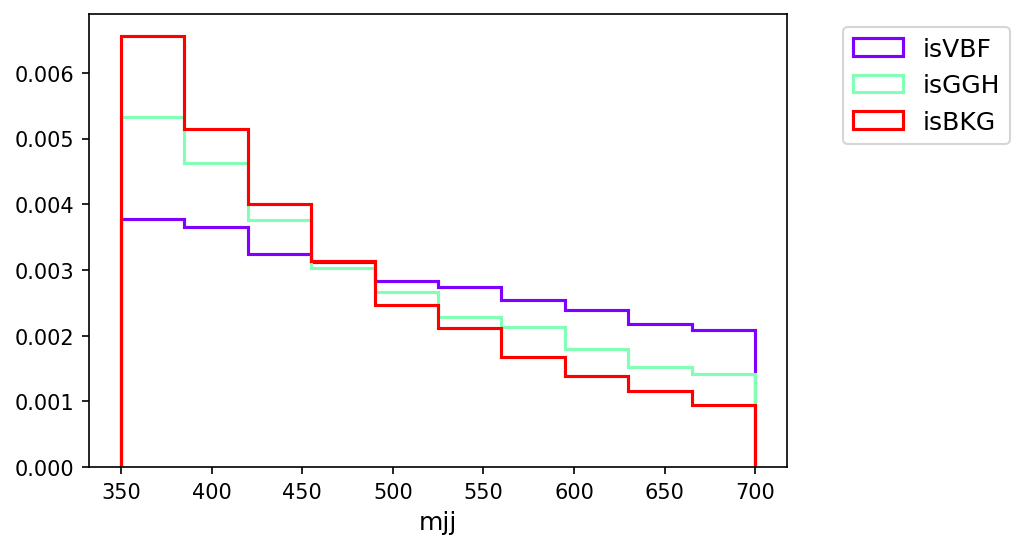

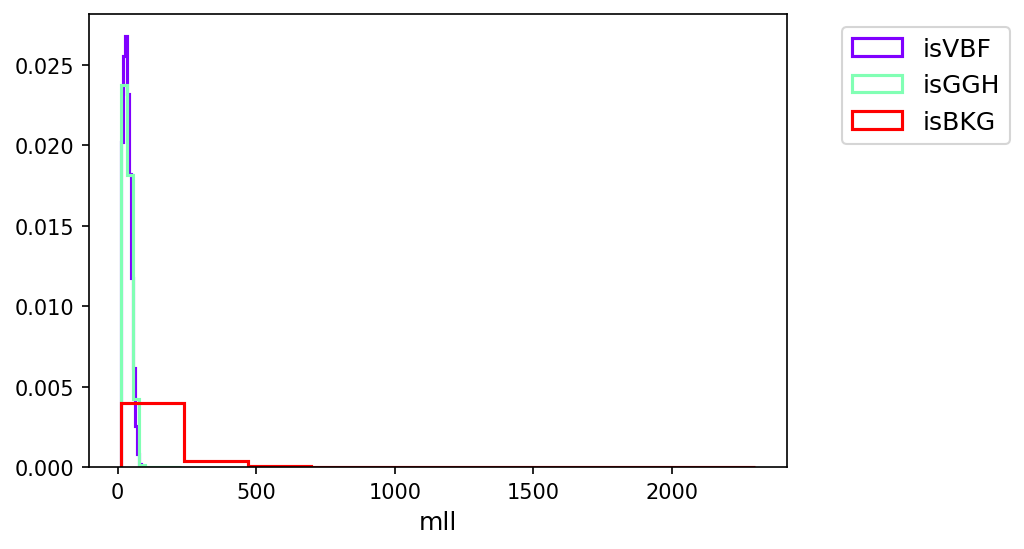

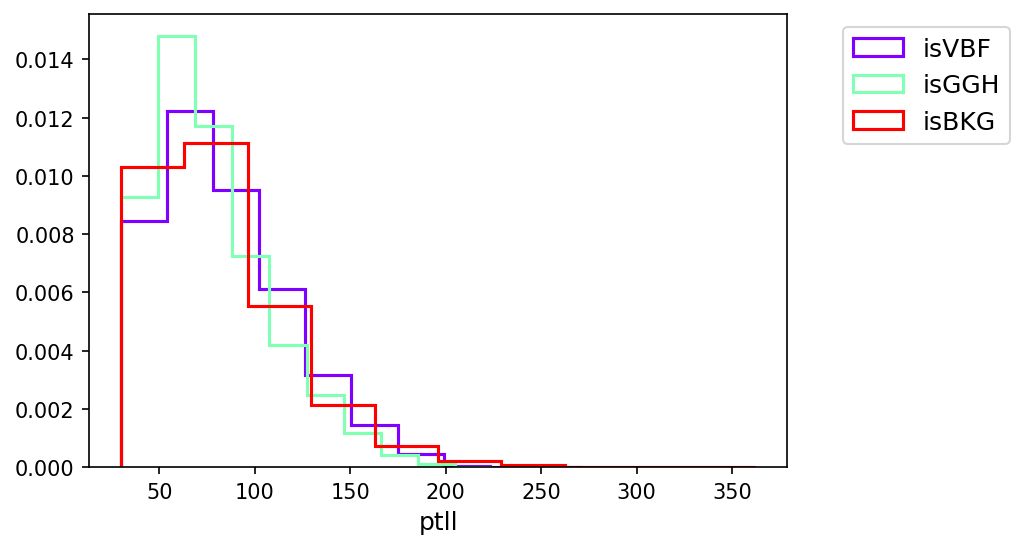

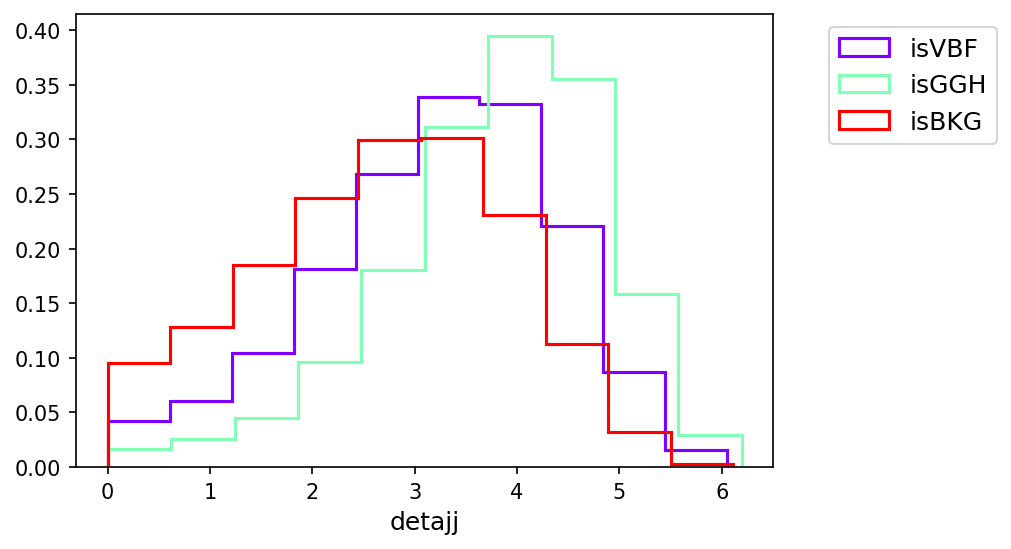

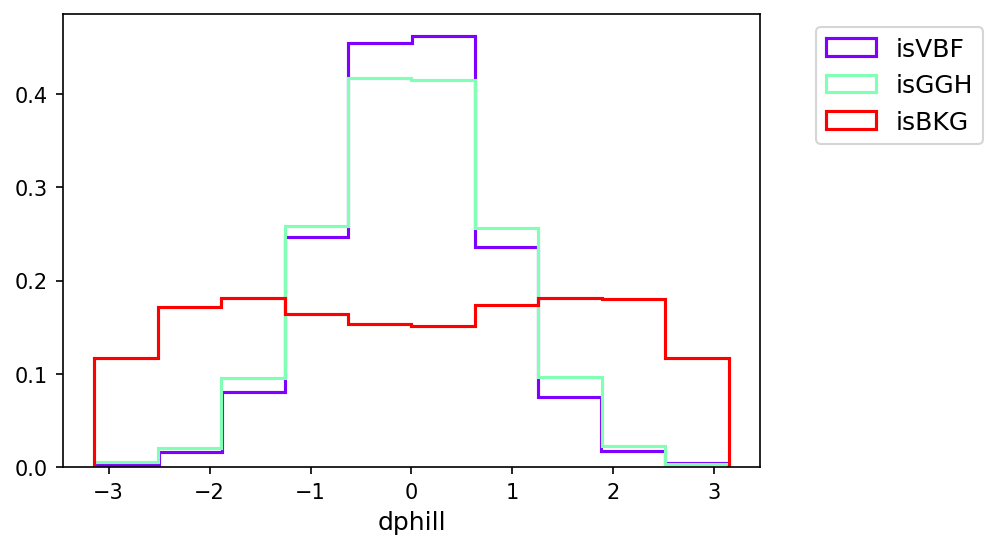

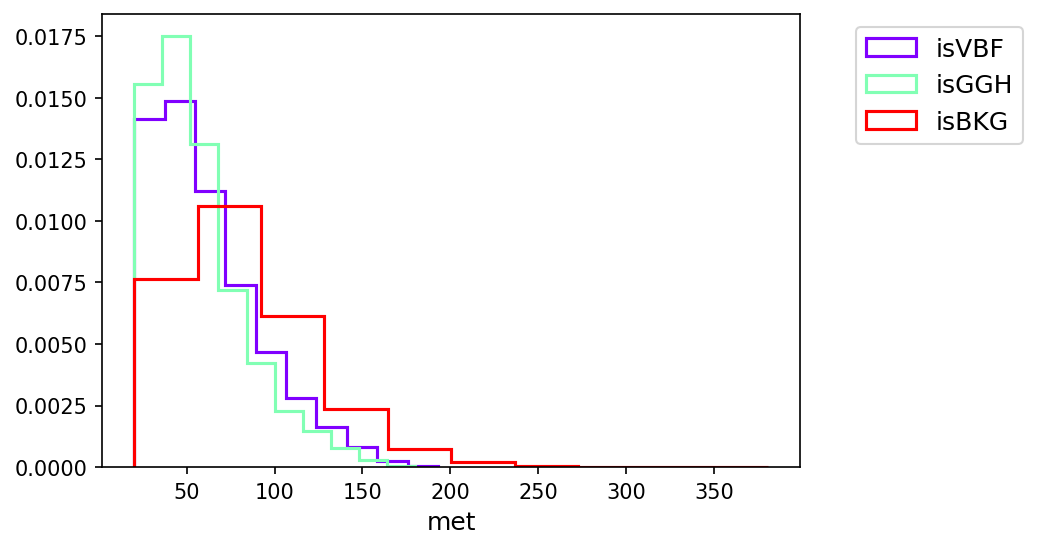

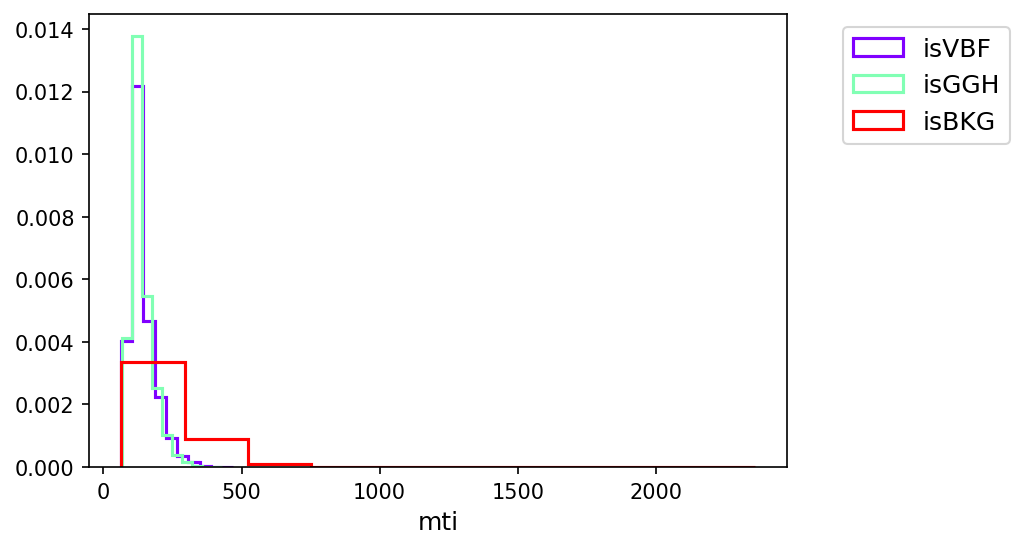

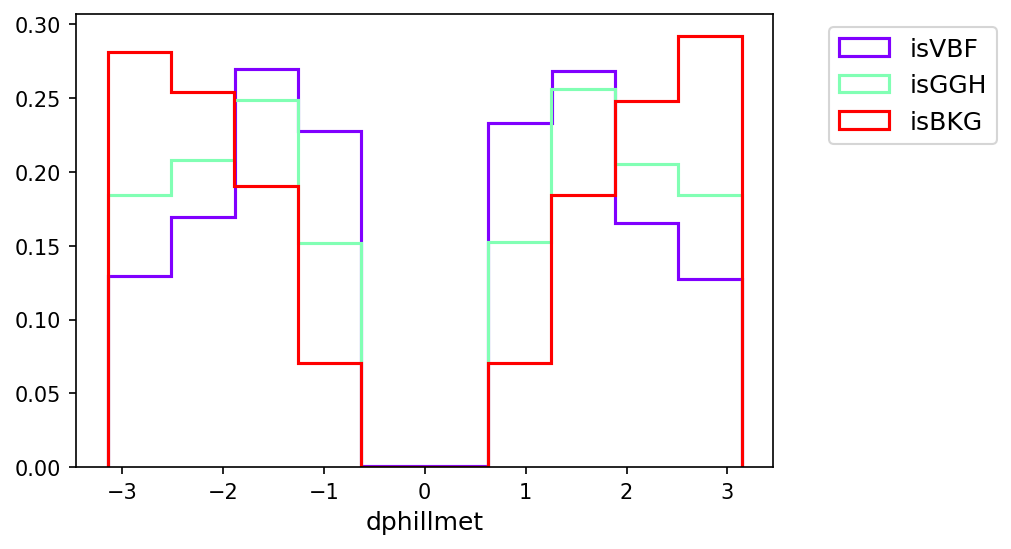

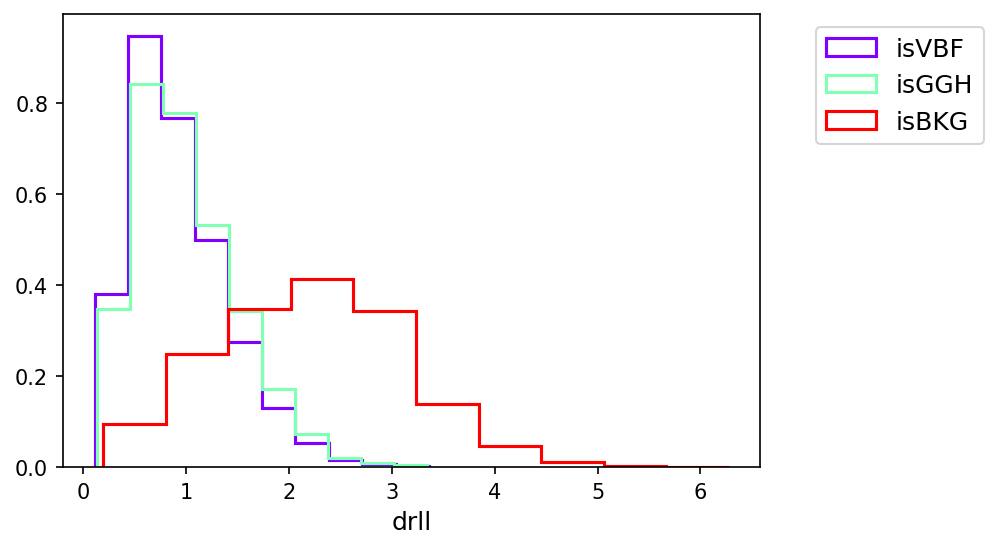

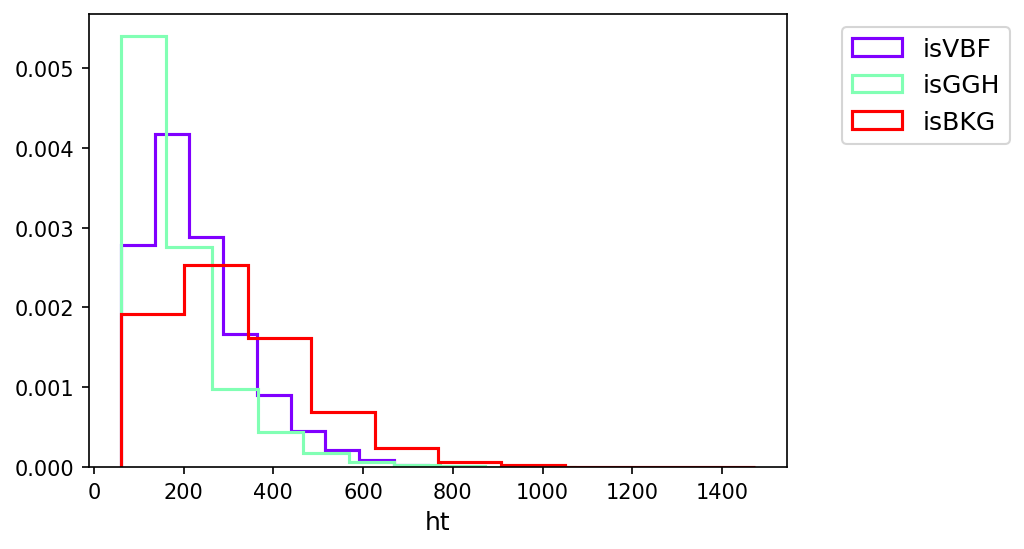

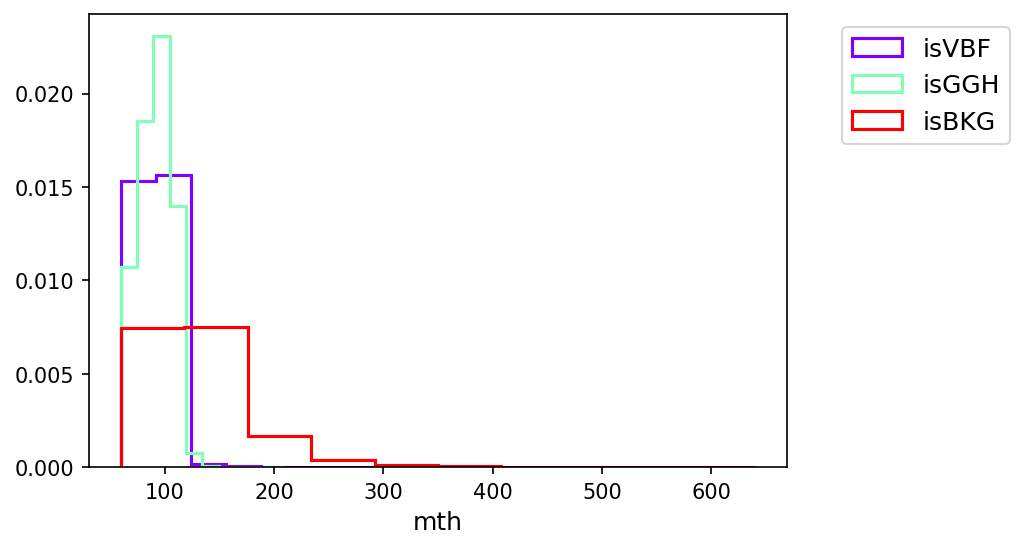

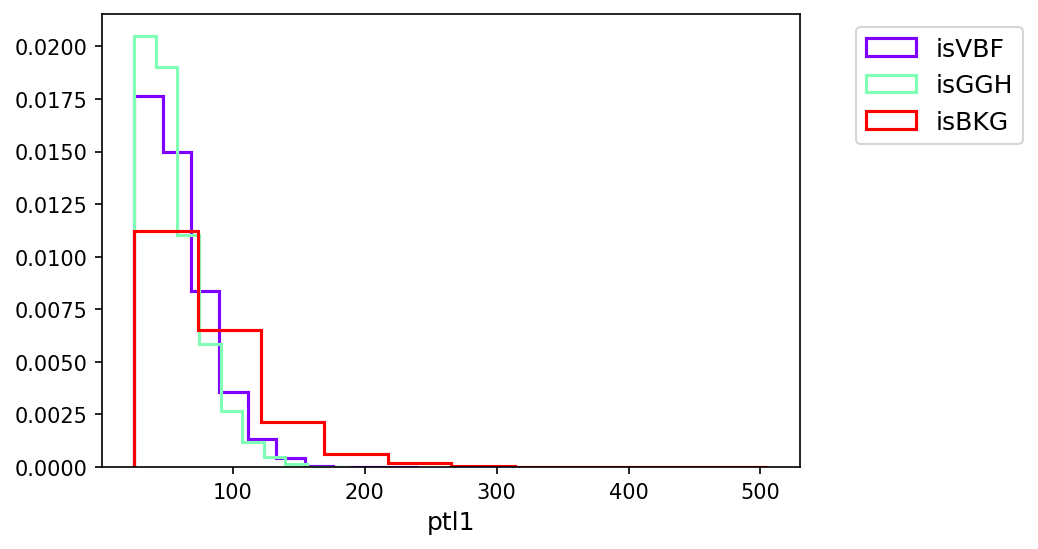

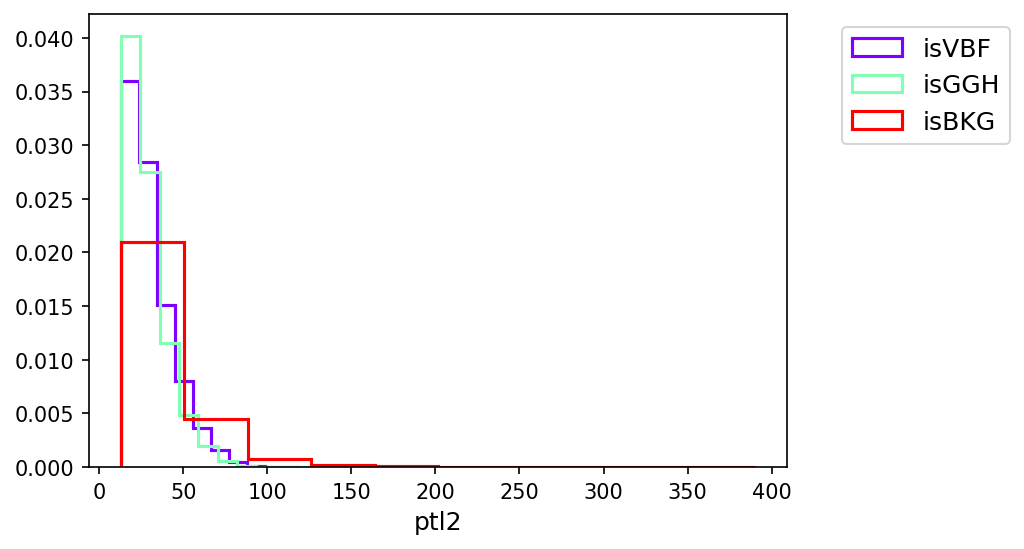

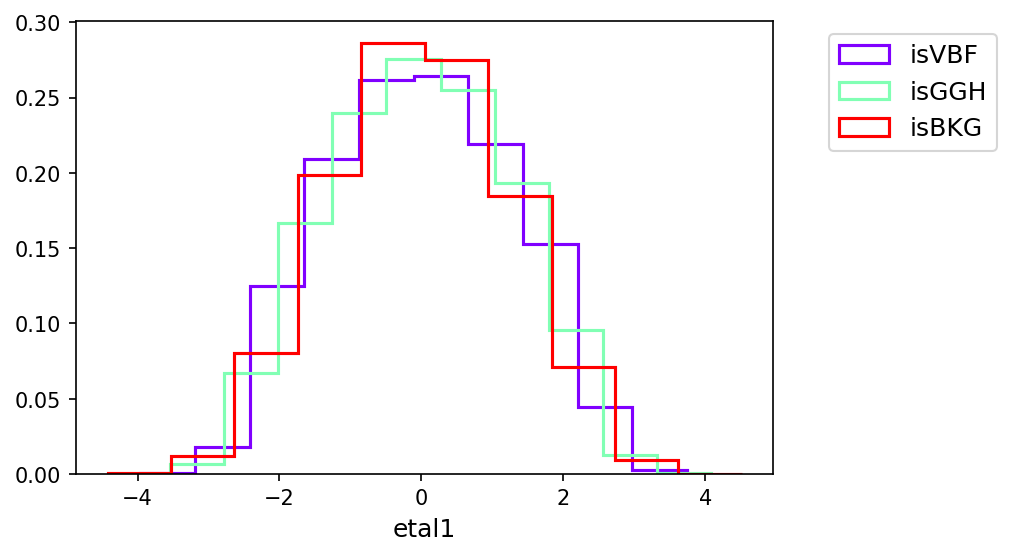

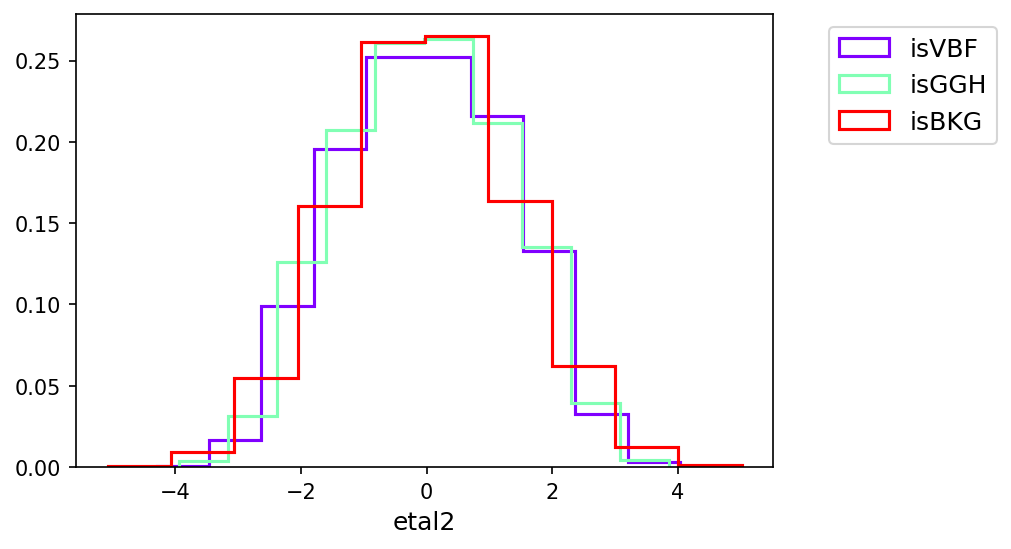

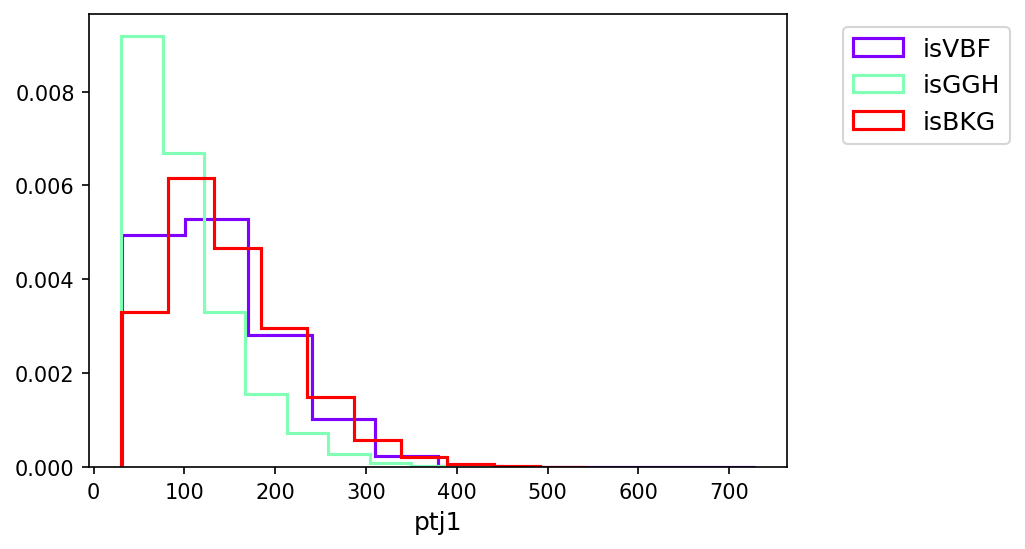

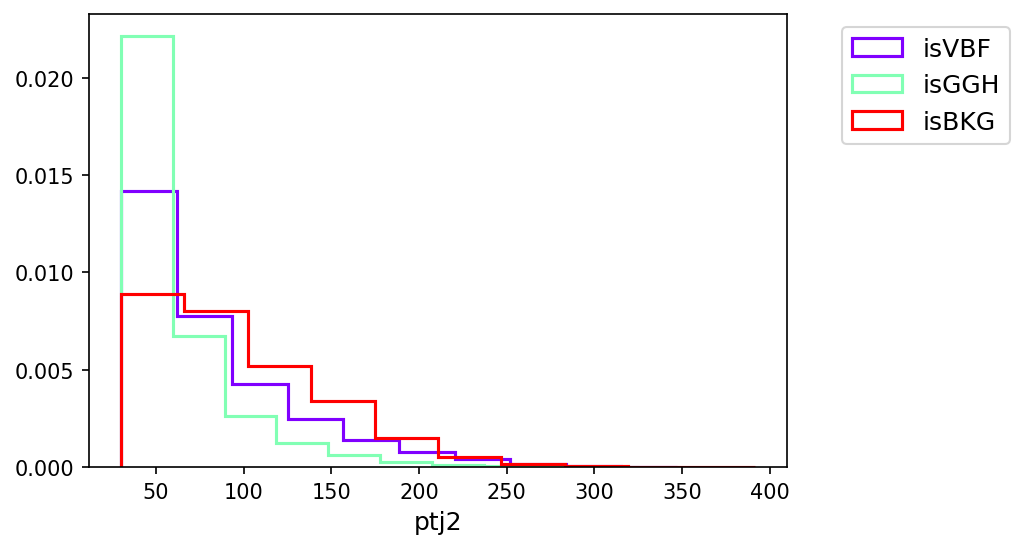

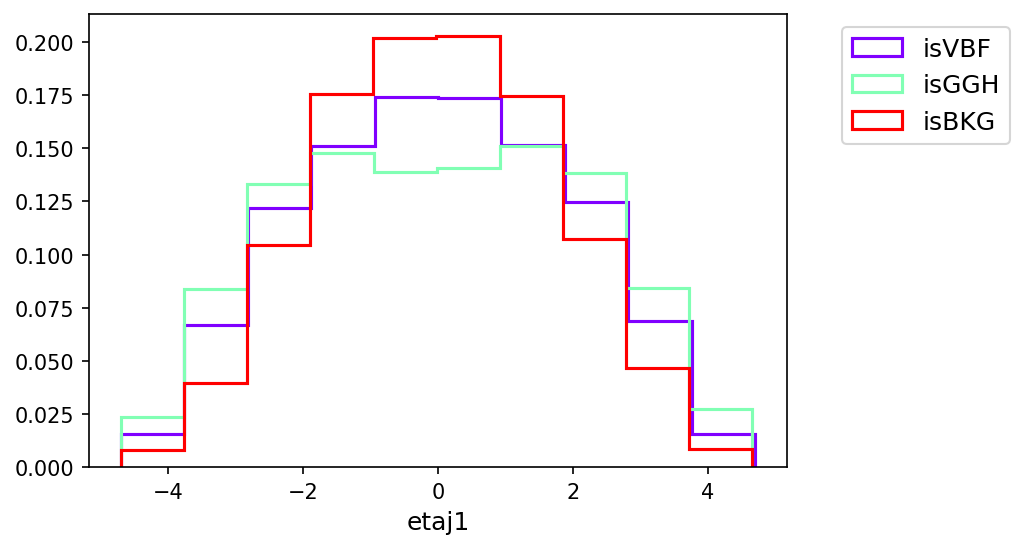

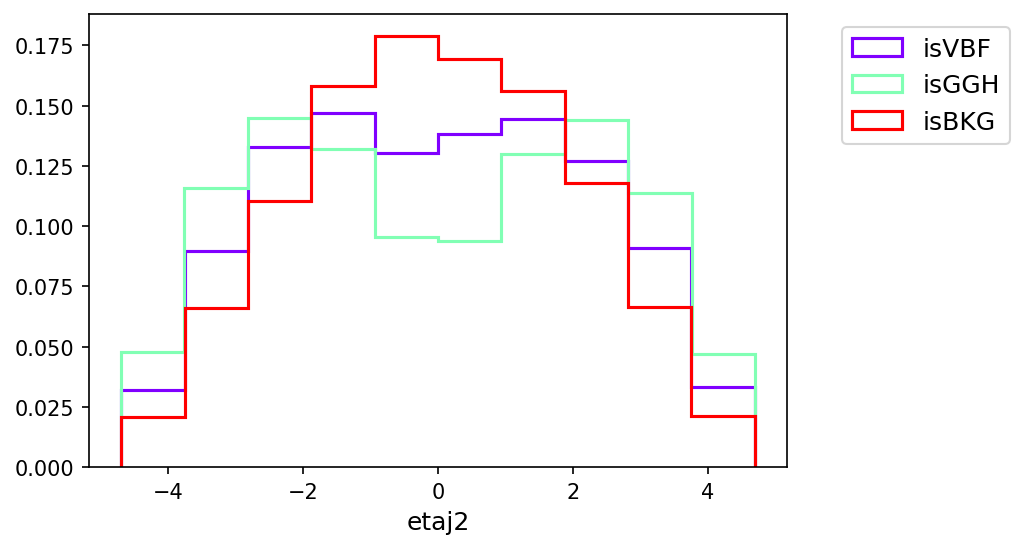

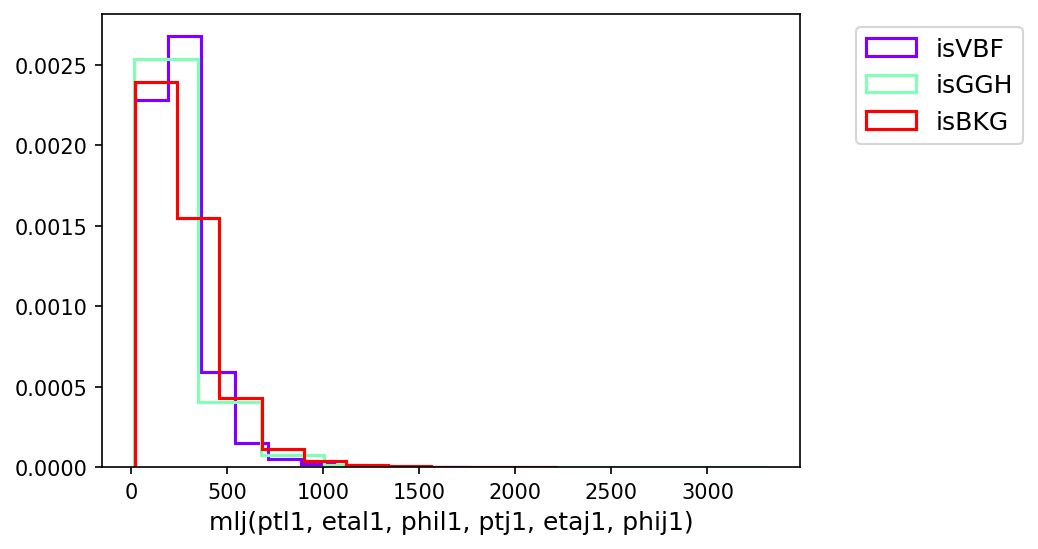

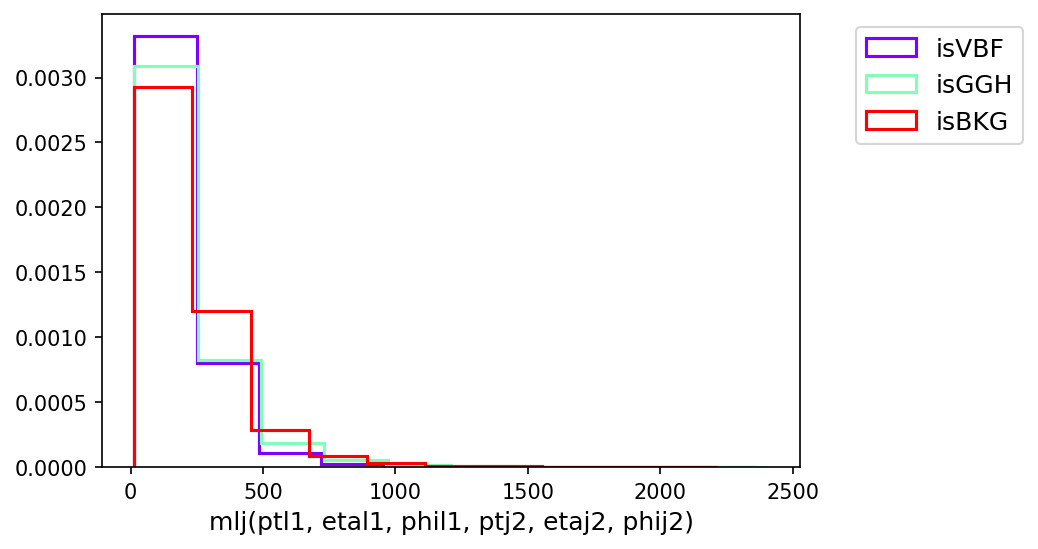

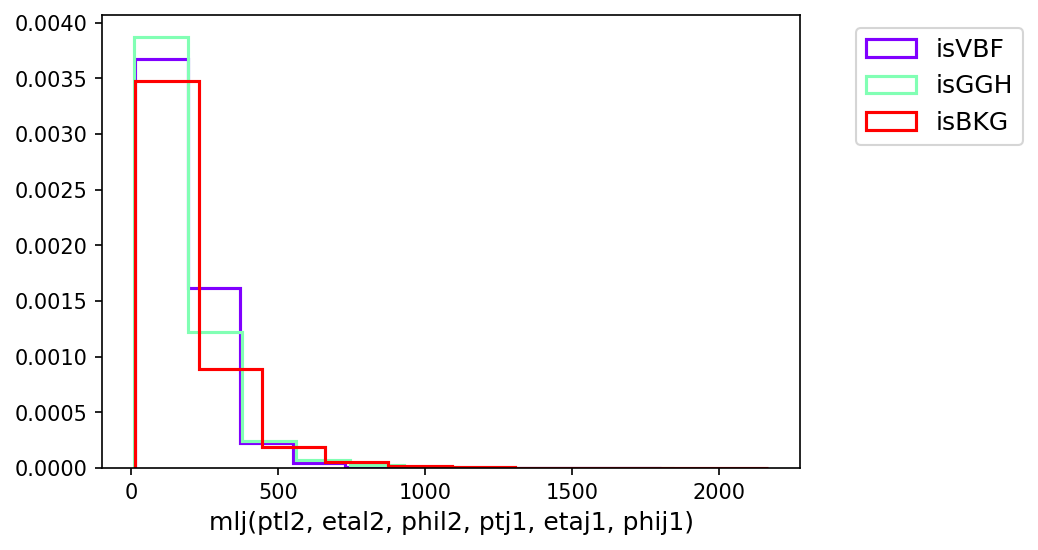

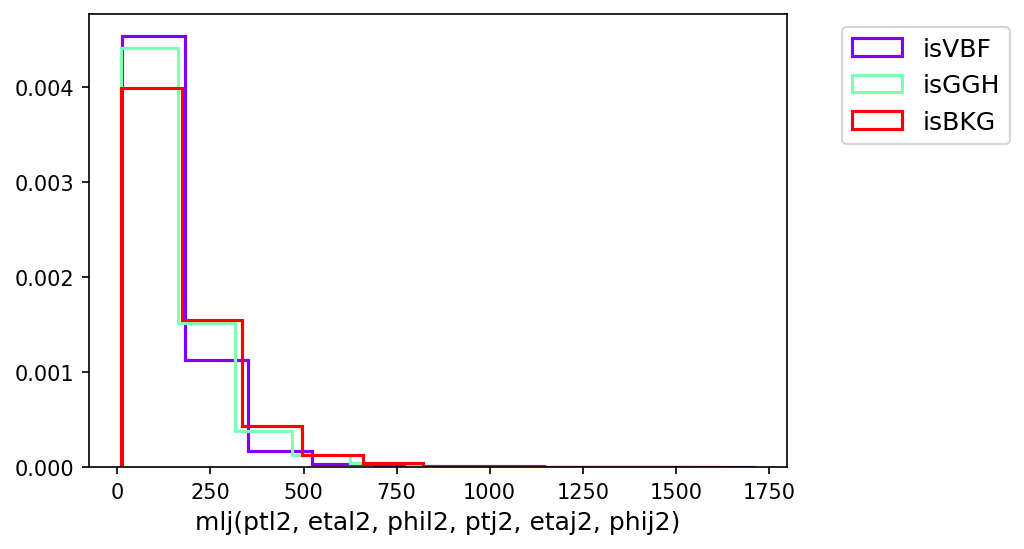

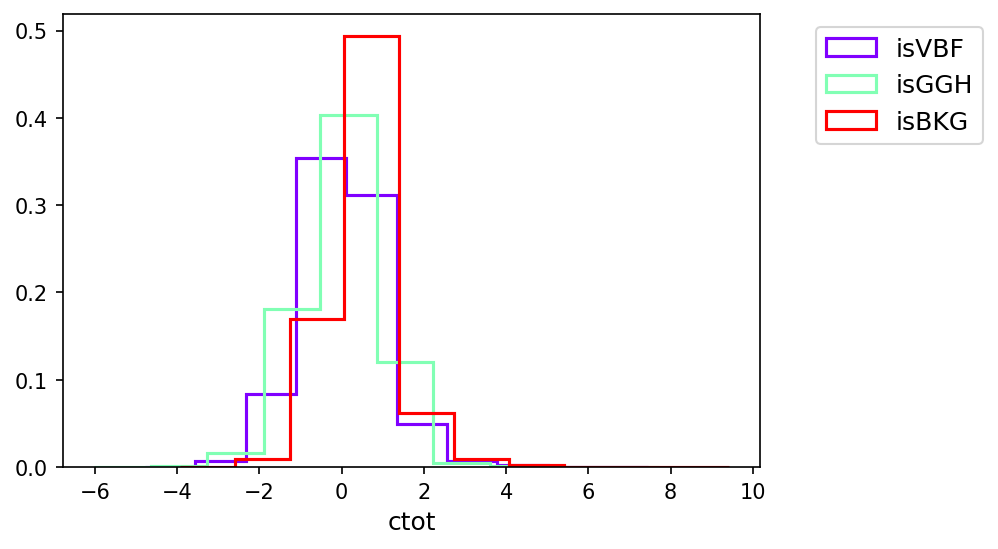

In [4]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 150

# List of features - the first 24 columns of our dataset
features = df.columns[:24]
# VBF, ggH and BKG labels
labels = df.columns[24:27]

color = cm.rainbow(np.linspace(0, 1, len(labels)))

for ft in features:
    for i,label in enumerate(labels):
        plt.hist(df[ft][df[label]==1], label=label,  histtype='step', density=True, color=color[i], linewidth=1.5 )

    plt.xlabel(ft,fontsize=12)
    plt.legend(loc=9, prop={'size': 12},bbox_to_anchor=(1.2, 1.))
    plt.show()

Let's now plot the distributions of the input features comnparing the various VBF models.

Do you spot any particular feature that is significantly different for the different models?

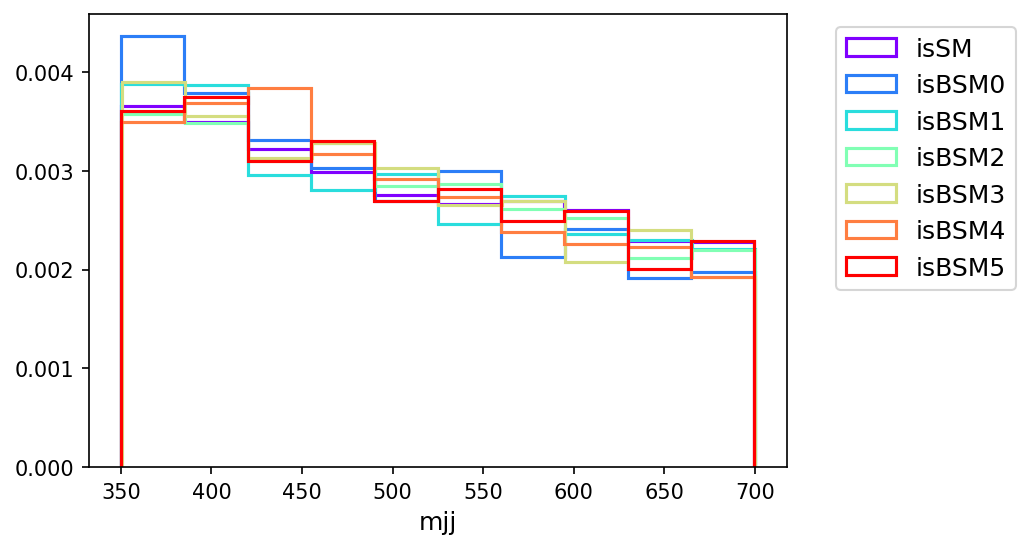

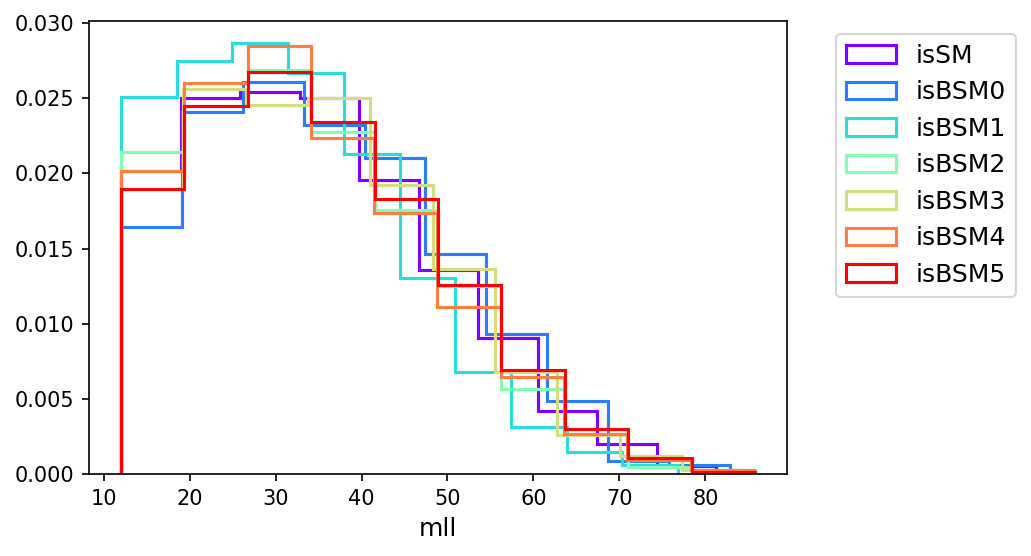

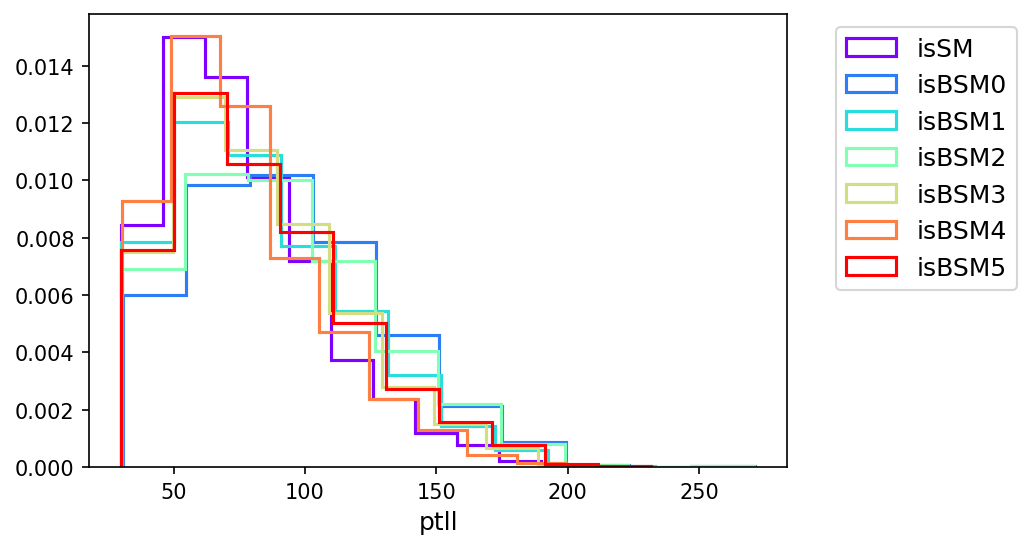

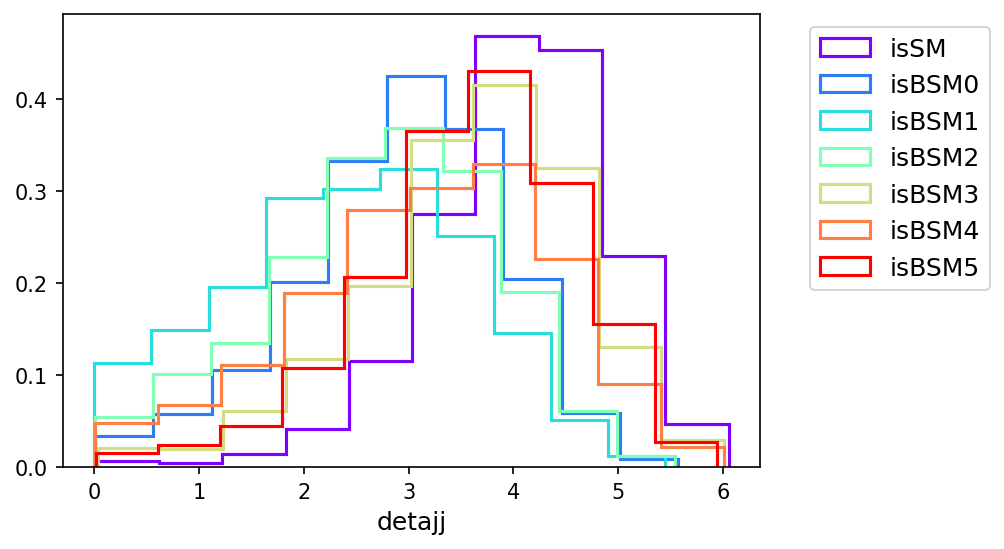

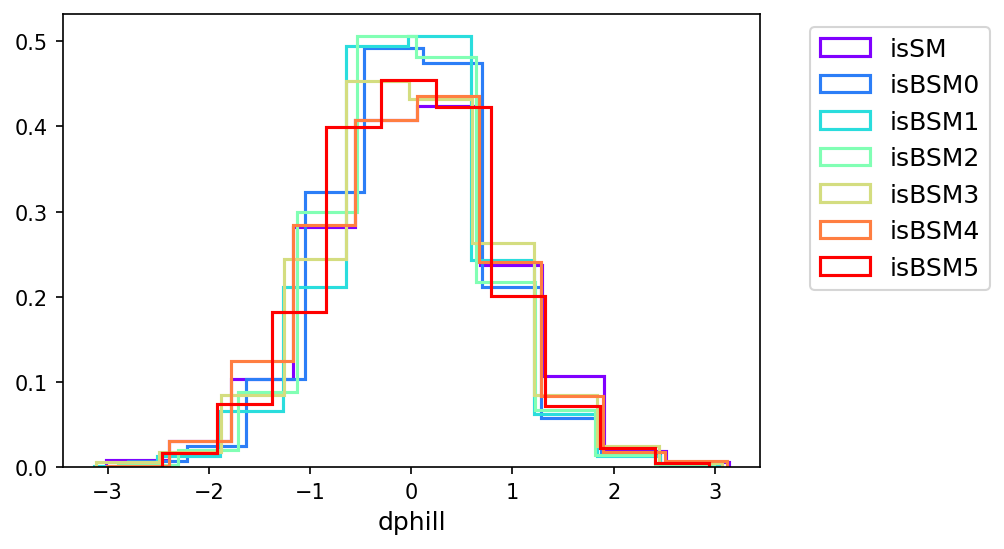

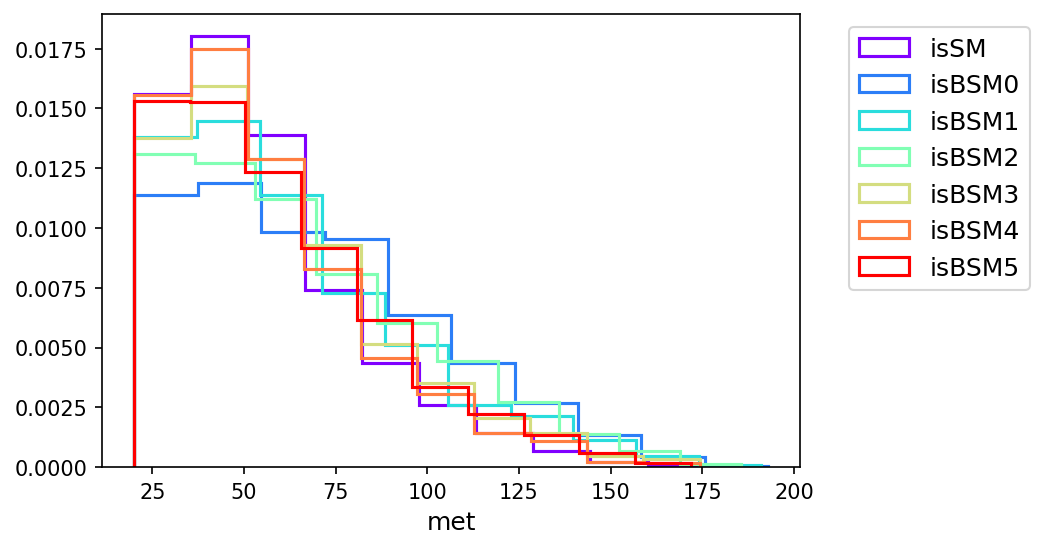

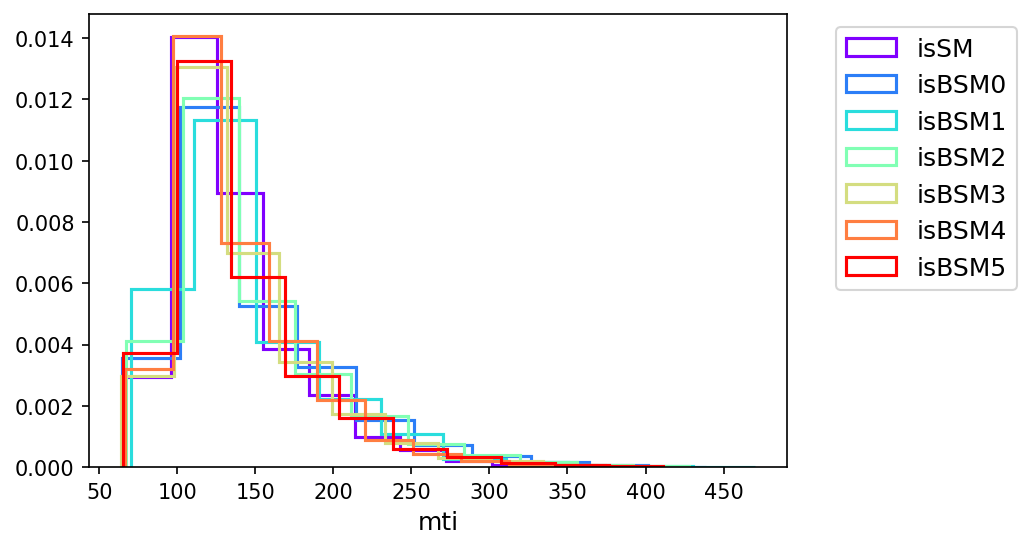

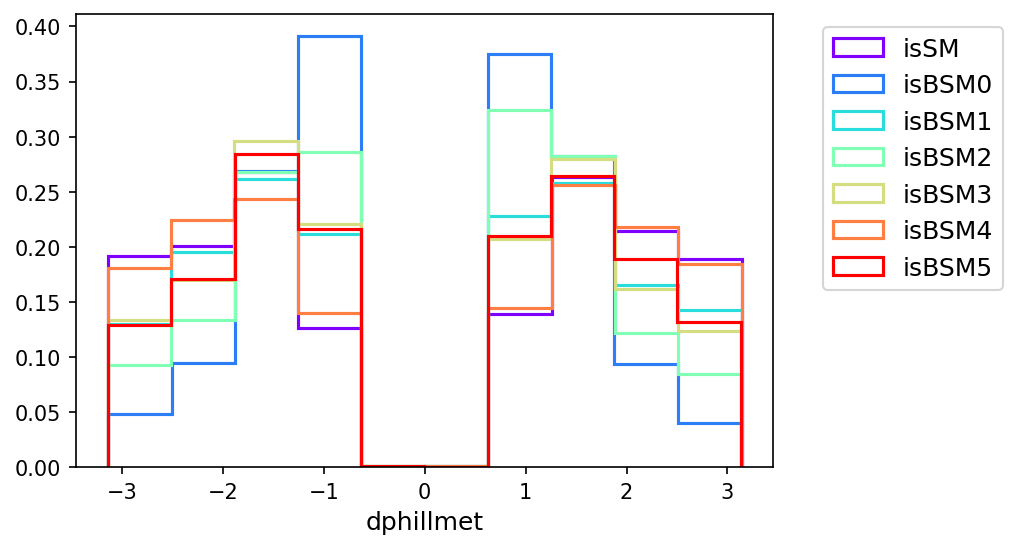

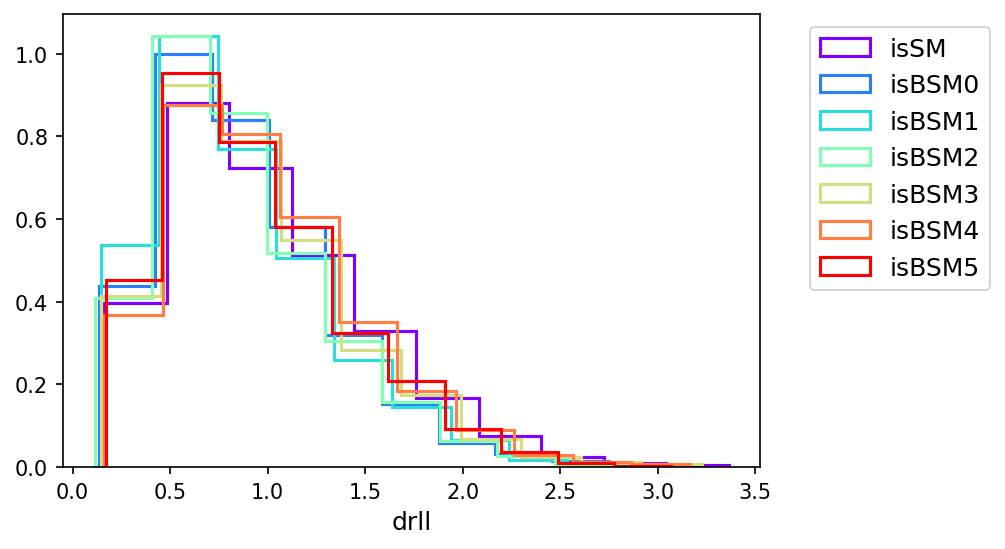

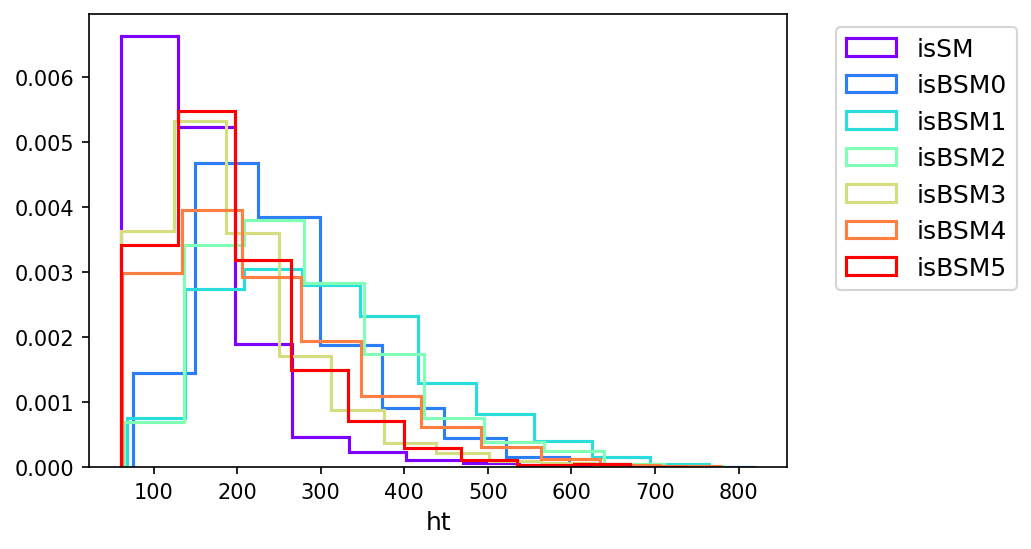

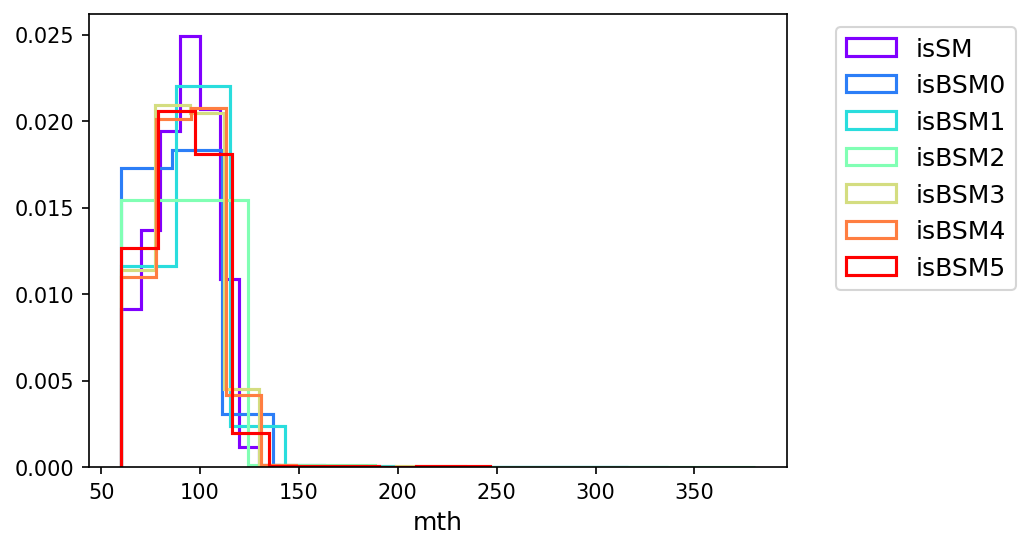

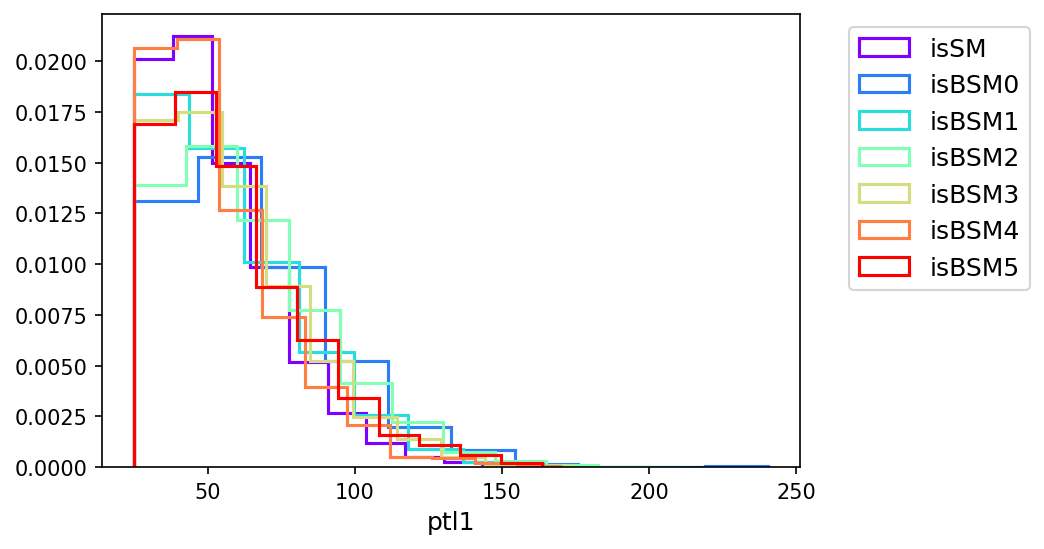

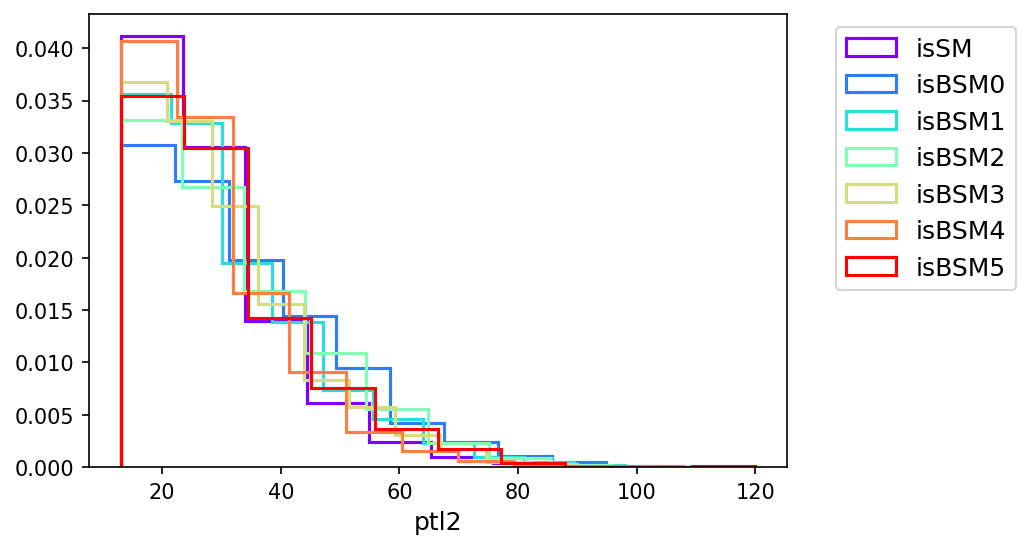

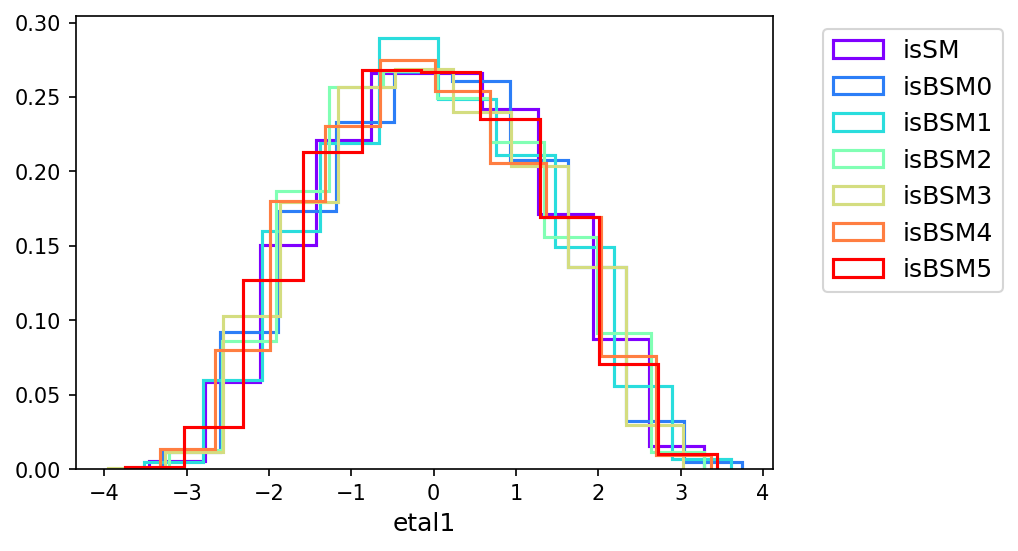

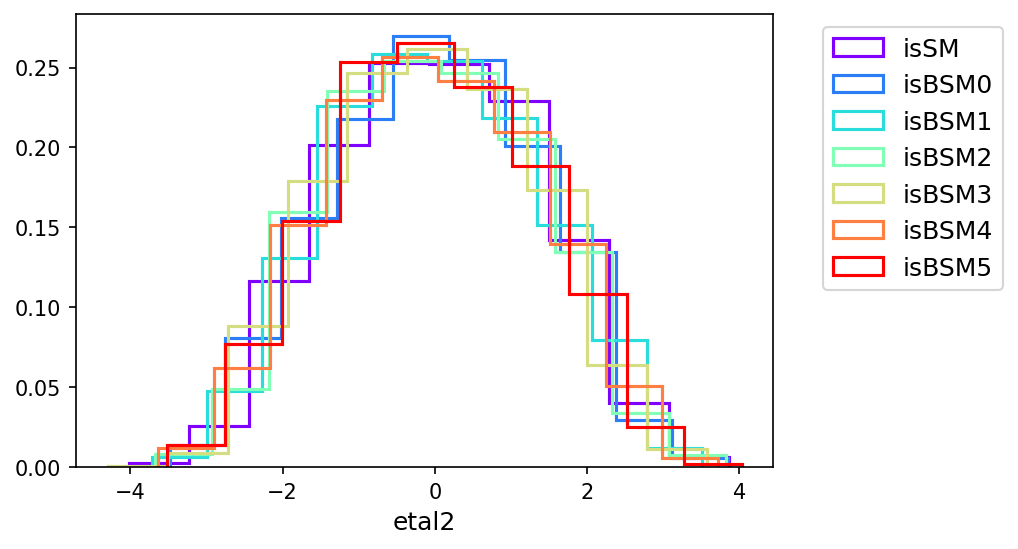

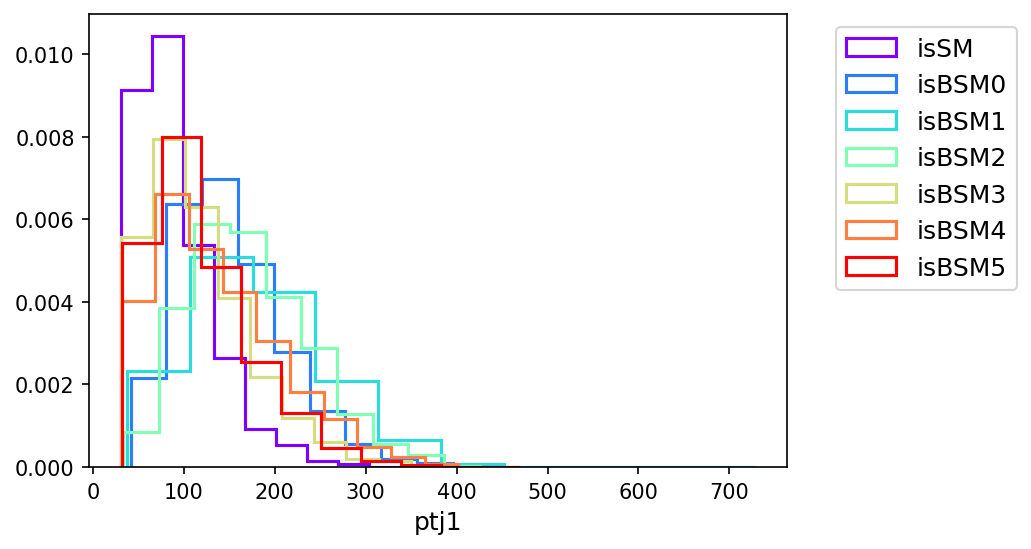

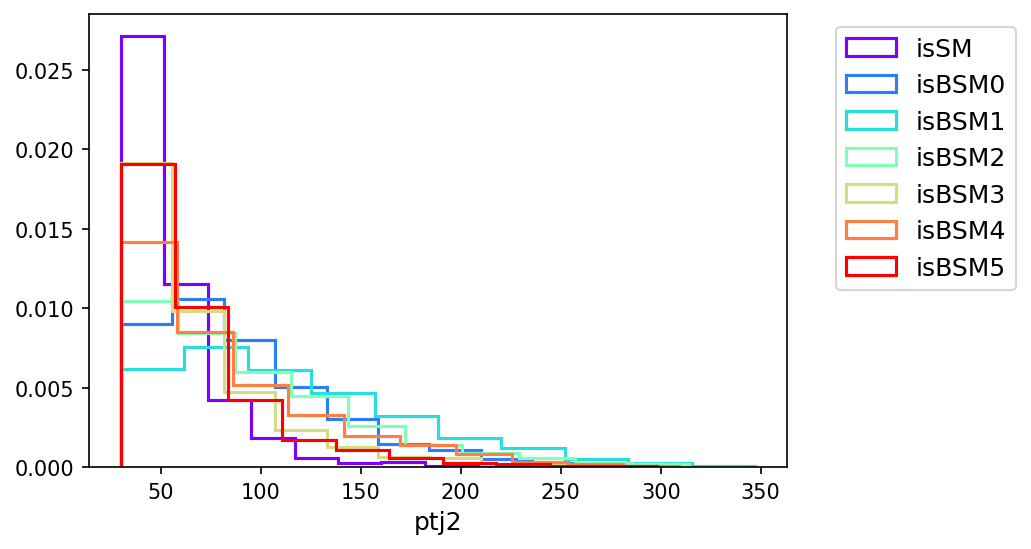

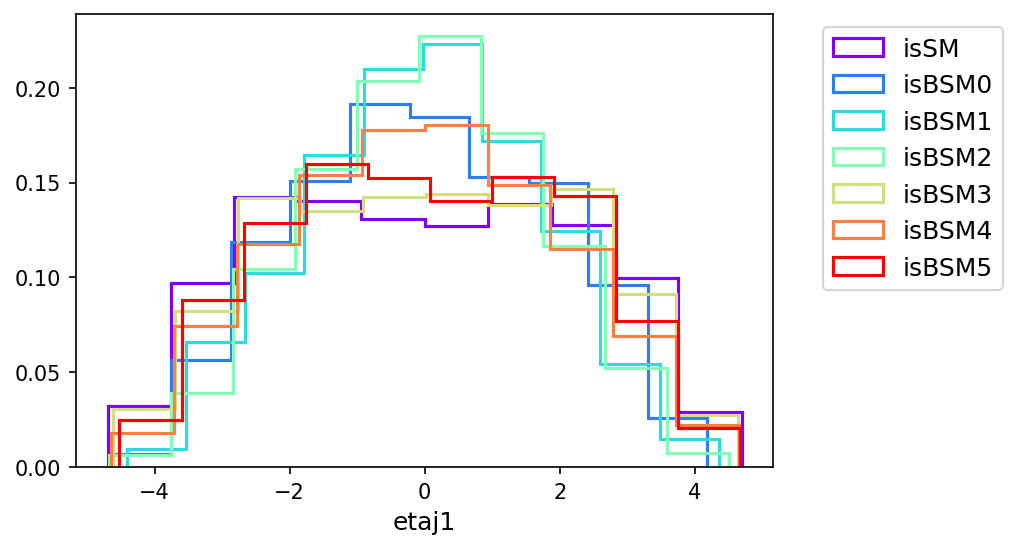

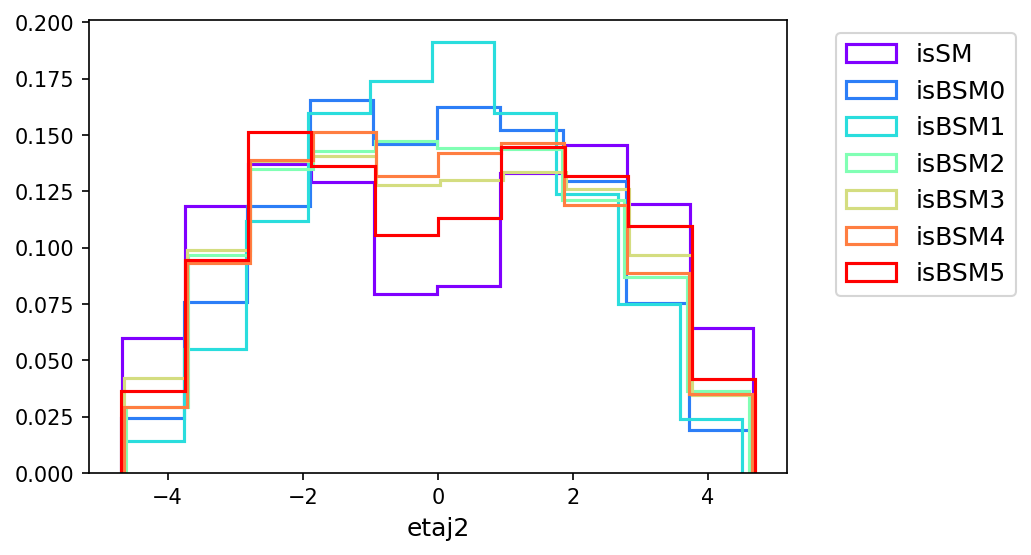

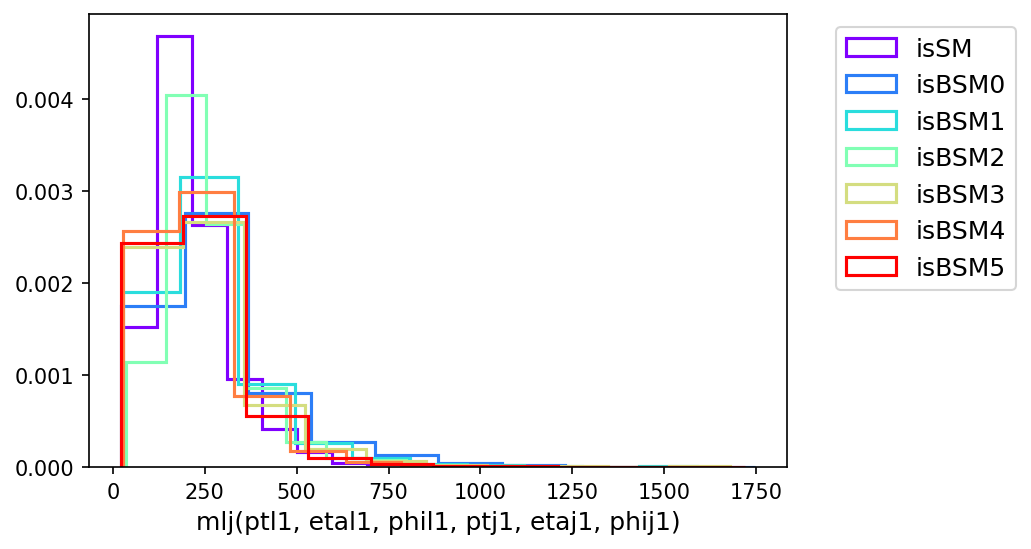

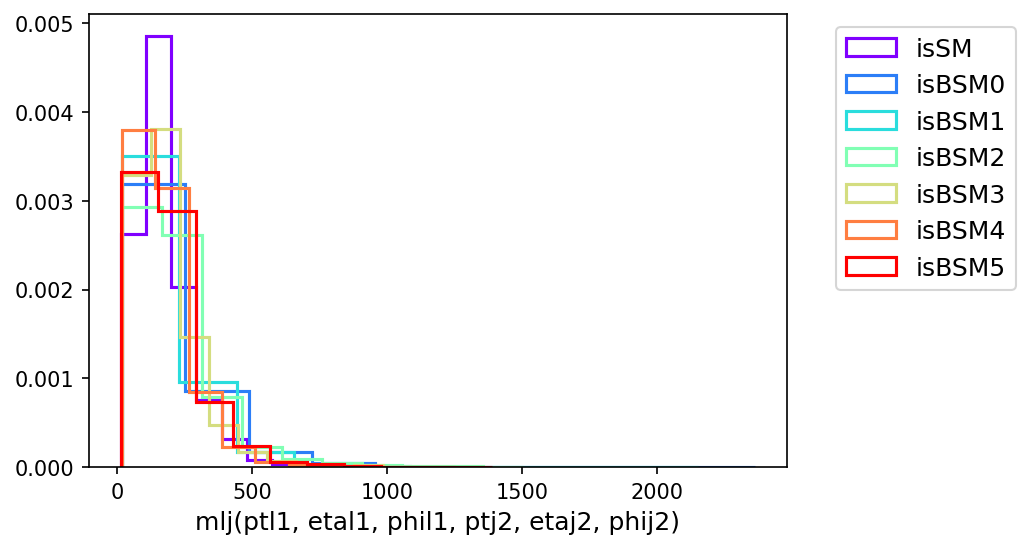

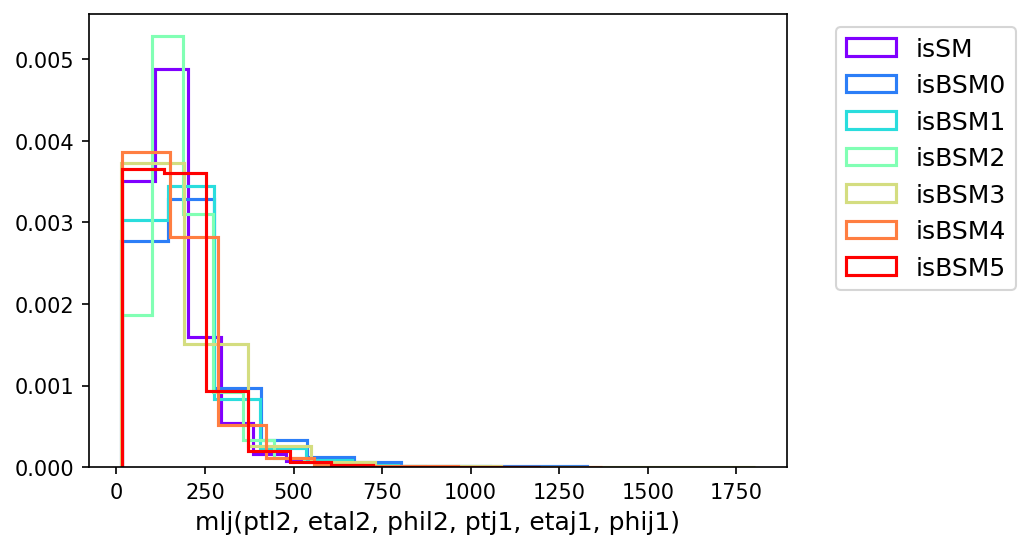

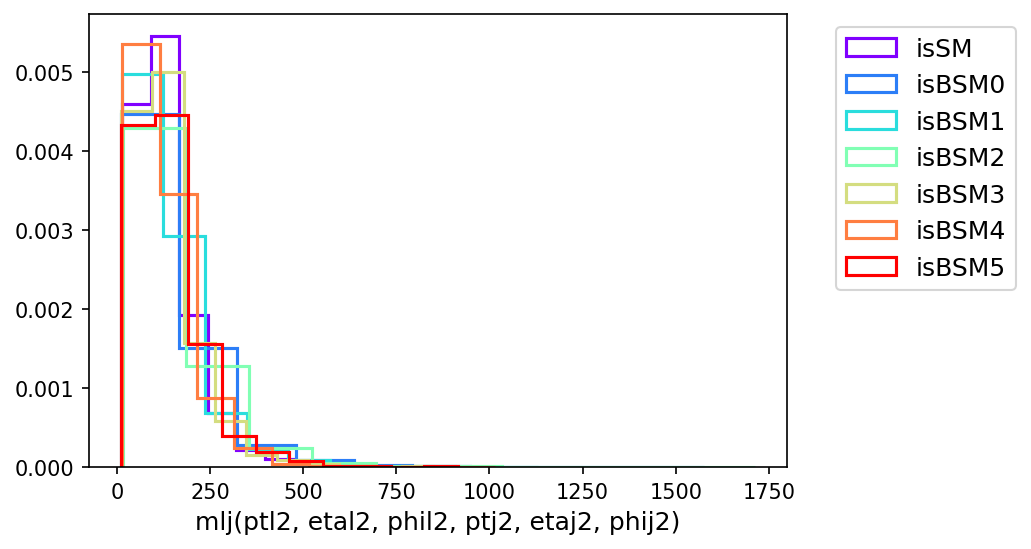

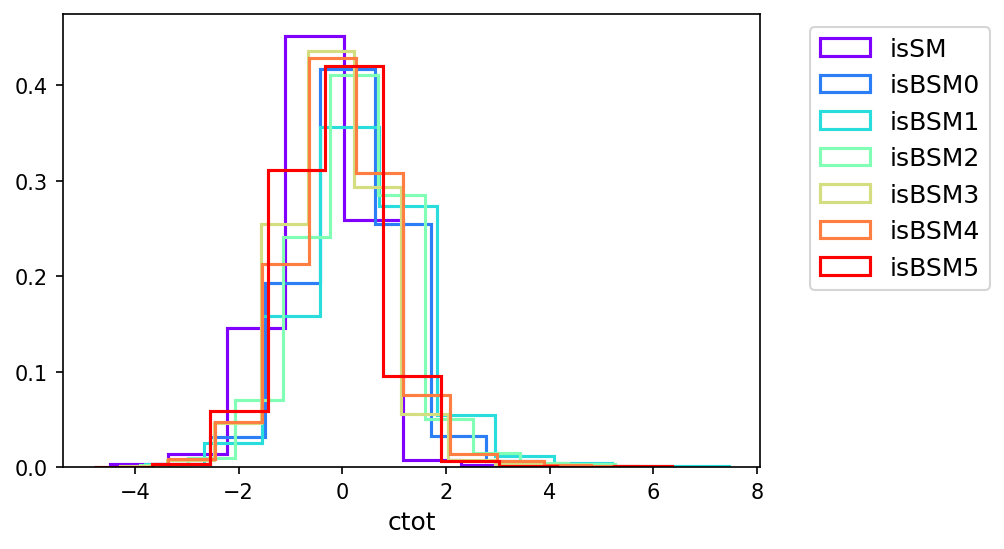

In [20]:
# List of labels containing SM and BSM models 
labels = [l for l in df.columns if ('isSM' in l or l.startswith('isBSM'))]

color = cm.rainbow(np.linspace(0, 1, len(labels)))

for ft in features:
    for i,label in enumerate(labels):
        plt.hist(df[ft][df[label]==1], label=label,  histtype='step', density=True, color=color[i], linewidth=1.5 )

    plt.xlabel(ft,fontsize=12)
    plt.legend(loc=9, prop={'size': 12},bbox_to_anchor=(1.2, 1.))
    plt.show()

The simplest way to achieve our goal, i.e. have a good discrimination among VBF, ggH and BKG, but at the same time being independent of the different VBF models, would be to drop the features that are sensitive to the VBF modelling but do not provide a significant discrimination among VBF, ggH and BKG.

But this is not always possible (as in the current use case), because some of the features that are good for the classification might also be good for distinguishing different models. Dropping those would mean a huge loss of classification power.

# Define the Domain Adaptation model

In order to achieve our goal we will adopt a particular flavor of Domain Adaptation, whose objective is to find a common representation for the source and target domains.

We want to build our Domain Adaptation model according to an Adversarial Deep Neural Network approach (also known as domain adversarial training), according to the following scheme:
<img src="http://lviliani.web.cern.ch/lviliani/FiguresForDANotebook/ADNN.png" width="800" height="800" />

The main components of the ADNN are:
- the *Classifier (C)*: a feed-forward Deep Neural Network with the goal to classify events in 3 classes (VBF signal, ggH and BKG);
- the *Adversary (A)*: a feed-forward Deep Neural Network connected to the second-to-last layer of C (representation) with the goal to classify different signal models.

*C* and *A* are trained in a competitive way with the final goal of maximizing the performance of *C* but simultaneously preventing *A* to identify the alternative signal models.
Schematically, the loss function we want to minimize is defined as follows:

<img src="http://lviliani.web.cern.ch/lviliani/FiguresForDANotebook/loss.png" width="400" height="400" />



We start by importing the relevant packages.

In [6]:
import tensorflow as tf
import tqdm
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Activation, Dense, Dropout, InputLayer
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import initializers
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle
import copy
print(tf.__version__)
from tensorflow.python.client import device_lib
tf.config.run_functions_eagerly(True)

2.7.0-rc1


Define the `NeuralNetworkWithDomainAdaptation` class as inherting from `tf.Module`. Define an `__init__` function that initializes the relevant class variables and calls the `build` function.

In the `build` function we define the structure of the model and we return the model weigths.

We define 3 Keras Sequential models:
- `model1` is the classifier network without the last output layer, i.e. the second-to-last layer is a representation of the input features;
- `model2` is the adversary network, connected to the second-to-last layer of `model1`;
- `model3` is just the output layer of the classifier that applies a softmax activation.

In the `fit` function we implement the epochs loop and we keep track of the classifier, adversary and total loss functions.

Note that we implemented a Batch Gradient Descent approach (gradients computed and weights updated every epoch using the full data), in which we call the `_train` function every epoch. A Mini-batch Gradient Descent approach can be easily implemented by splitting the training data in smaller batches.

The `_train` function contains the custom training strategy, implementing the C and A loss functions using the Categorical Cross Entropy Keras loss. In this function we compute the gradients of the loss functions and update the weights.

Take your time to look carefully at the loss definition and understand the gradients. Note that:

- we first compute the gradient of the total loss L(C+A) with respect to the classifier weights;
- then we compute the gradient of the adversary loss L(A) with respect to the adversary weights;

In [7]:
class NeuralNetworkWithDomainAdaptation ( tf.Module ):
    
    def __init__ (self, nEpochs, learning_rate1, learning_rate2, alpha, N_NODES, n_layers1, n_layers2, n_features, n_outputsC=3, n_outputsA=7):
        self.learning_rate1 = learning_rate1
        self.learning_rate2 = learning_rate2
        self.optimizer  = tf.optimizers.Adam (self.learning_rate1)
        self.optimizer2 = tf.optimizers.Adam (self.learning_rate2)
        self.nEpochs = nEpochs
        self.alpha = alpha
        self.N_NODES = N_NODES
        self.n_layers1 = n_layers1
        self.n_layers2 = n_layers2
        self.n_features = n_features
        self.n_outputsC = n_outputsC
        self.n_outputsA = n_outputsA
        self.weightsC, self.weightsA = self.build (self.n_features, self.N_NODES)

    # Define the structure of the model
    def build (self, n_input, N_NODES):
        # initializer = initializers.Ones()

        # Classifier model
        self.model1 = Sequential()
        self.model1.add(Dense (self.N_NODES, activation = 'relu', input_dim  = n_input))
        for i in range(self.n_layers1):
            self.model1.add(Dense (self.N_NODES, activation = 'relu'))
            # self.model1.add(Dropout(0.2))

        # Adversary model
        self.model2 = Sequential()
        self.model2.add(Dense (self.N_NODES, activation = 'relu', input_dim = self.N_NODES))
        for i in range(self.n_layers2):
            self.model2.add(Dense (self.N_NODES, activation = 'relu'))
            # self.model2.add(Dropout(0.2))
        self.model2.add(Dense(self.n_outputsA, activation = 'softmax'))
       
        # Classifier output
        self.model3 = Sequential()
        self.model3.add(Dense (self.n_outputsC, activation = 'softmax',input_dim = self.N_NODES))      
        
        return (self.model1.weights + self.model3.weights, self.model2.weights)

    # Performs the epochs loop and the actual training.
    # Monitors the training and validation loss functions, both for the classifier and the adversary.
    # Returns the classifier categorical accuracy.
    def fit (self, X, Y, Y_adv, X_val, Y_val, Y_adv_val, show_loss = False):
        losses = []
        losses_adv = []
        losses_cl = []

        losses_val = []
        losses_adv_val = []
        losses_cl_val = []

        self.means = np.mean ( X, axis = 0)
        self.sigmas = np.std ( X, axis = 0)

        for iEpoch in tqdm.tqdm(range(self.nEpochs)):
                l, l_adv, l_cl, l_val, l_adv_val, l_cl_val = self._train (X, Y, Y_adv, X_val, Y_val, Y_adv_val)
                losses.append ( l )
                losses_adv.append ( l_adv )
                losses_cl.append ( l_cl )
                losses_val.append ( l_val )
                losses_adv_val.append ( l_adv_val )
                losses_cl_val.append ( l_cl_val )

        losses = np.array(losses)
        losses_adv = np.array(losses_adv)
        losses_cl = np.array(losses_cl)
               
        losses_val = np.array(losses_val)
        losses_adv_val = np.array(losses_adv_val)
        losses_cl_val = np.array(losses_cl_val)
               
        plt.plot (losses_adv, color = "y", label='Training set')
        plt.plot (losses_adv_val, color ='orange', label = "Validation set")
        plt.xlabel ("Epoch"); plt.ylabel ("Loss(A)")
        plt.legend(frameon=False)
        plt.show()

        plt.plot (losses_cl, color='r', label='Training set')
        plt.plot (losses_cl_val, color='darkred', label='Validation set')
        plt.xlabel ("Epoch"); plt.ylabel ("Loss(C)")
        plt.legend(frameon=False)
        plt.show()
        
        plt.plot (losses, color='c', label='Training set')
        plt.plot (losses_val, color='tab:blue', label='Validation set')
        plt.xlabel ("Epoch"); plt.ylabel ("Loss(C+A)")
        plt.legend(frameon=False)
        plt.show()
        
        ca = tf.keras.metrics.CategoricalAccuracy()
        ca.update_state(Y, self.predict_proba(X))
        
        return ca.result().numpy()

    # Some ancillary functions to save the model weights, reset the optimizers or set specific parameters.
    def save_weights(self, model_name):
        self.model1.save_weights(model_name+'_weights_1')
        self.model2.save_weights(model_name+'_weights_2')
        self.model3.save_weights(model_name+'_weights_3')
    
    def load_weights(self, model_name):
        self.model1.load_weights(model_name+'_weights_1')
        self.model2.load_weights(model_name+'_weights_2')
        self.model3.load_weights(model_name+'_weights_3')
        
    def save_model(self, model_name):
        self.model1.save("saved_models/"+model_name+"_1")
        self.model2.save("saved_models/"+model_name+"_2")
        self.model3.save("saved_models/"+model_name+"_3")

    def reset_optimizers(self):
        self.optimizer  = tf.optimizers.Adam (self.learning_rate1)
        self.optimizer2 = tf.optimizers.Adam (self.learning_rate2)
        
    def set_alpha(self, alpha):
        self.alpha = alpha
    
    def set_epochs(self, epochs):
        self.nEpochs = epochs
 

    # Applies a pre-processing to the input features and returns the classifier representation.
    @tf.function
    def representation (self, X):
        ppX = (X - self.means)/self.sigmas
        return  self.model1 (ppX) 

    # Returns the classifier output
    #@tf.function
    def predict_proba (self, X):
        ppX2 = self.representation (X)
        return tf.clip_by_value ( self.model3 (ppX2), 1e-7, 1. - 1e-7 )

    # Returns the adversary output
    #@tf.function
    def predict_proba_adv (self, X):
        ppX2 = self.representation (X)
        return tf.clip_by_value ( self.model2 (ppX2), 1e-7, 1. - 1e-7 )

    @tf.function
    def _train (self, X, Y, Y_adv, X_val, Y_val, Y_adv_val):
        Y_true = tf.cast (Y, tf.float32)
        Y_true_val = tf.cast (Y_val, tf.float32)
        
        Y_true_adv = tf.cast (Y_adv, tf.float32)
        Y_true_adv_val = tf.cast (Y_adv_val, tf.float32)

        with tf.GradientTape() as gt, tf.GradientTape() as gt_adv:
            #gt.watch ( self.weightsC )
            Y_hat = self.predict_proba (X) #N3(N1(x))
            Y_hat_adv = self.predict_proba_adv (X)
            Y_hat_val = self.predict_proba (X_val) #N3(N1(x)) validation set
            Y_hat_adv_val = self.predict_proba_adv (X_val)
            
            ## Training set
            # Use the categorical cross-entropy as loss function for the adversary
            cce_adv = tf.keras.losses.CategoricalCrossentropy()
            
            # Sums the contents of each row of the Y_true_adv tensor to get a 1D tensor with N_events length
            # containing 0 if the event is not VBF or 1 if it is VBF (SM or BSM)
            sum_adv = tf.math.reduce_sum(Y_true_adv, axis=1)
            
            # The second term in the multiplication is used to set the loss at 0 for non-VBF events
            # i.e. the loss of the adversary is computed only for VBF (SM and BSM) events
            loss_adv = tf.math.reduce_sum(( cce_adv( Y_true_adv, Y_hat_adv) )*( tf.cast( sum_adv.numpy()!=0, tf.float32 ) ))
            
            # Divide the loss for the total number of VBF (SM and BSM) events to get the average loss
            loss_adv = loss_adv / tf.cast((tf.math.reduce_sum(sum_adv, axis=0)).numpy(),tf.float32 )
            
            # Use the categorical cross-entropy as loss function for the classifier
            cce = tf.keras.losses.CategoricalCrossentropy()
            loss_cl = tf.reduce_mean ( cce( Y_true, Y_hat ) )
            
            # The overall loss is L(C) - alpha*L(A)
            loss = loss_cl - self.alpha*loss_adv
            
            ## Validation set
            cce_adv_val = tf.keras.losses.CategoricalCrossentropy()
            sum_adv_val =tf.reduce_sum(Y_adv_val, axis=1)
            loss_adv_val = tf.math.reduce_sum(( cce_adv_val( Y_adv_val, Y_hat_adv_val) )*( tf.cast( sum_adv_val.numpy()!=0, tf.float32 ) ))
            loss_adv_val = loss_adv_val / tf.cast((tf.math.reduce_sum(sum_adv_val, axis=0)).numpy(), tf.float32)
            
            cce_val = tf.keras.losses.CategoricalCrossentropy()
            loss_cl_val = tf.reduce_mean (cce_val( Y_true_val, Y_hat_val ) )
            
            loss_val = loss_cl_val - self.alpha*loss_adv_val

            # Compute the gradient of the overall loss with respect to the classifier weights
            gradients = gt.gradient ( loss, self.weightsC )
            # Then compute the gradient of L(A) with respect to the adversary weights
            gradients_adv = gt_adv.gradient ( loss_adv, self.weightsA )

        # Apply the gradients
        self.optimizer.apply_gradients ( zip(gradients, self.weightsC) )
        self.optimizer2.apply_gradients ( zip(gradients_adv, self.weightsA) )
        
        return loss, loss_adv, loss_cl, loss_val, loss_adv_val, loss_cl_val

# Training of the ADNN model

Now that we have defined the model structure, let's do the actual training.

## Extract the input features and labels from the original dataset and split in training (80%) and validation (20%)

First we split our data in 2 randomly chosen subsets: the first one ($80\%$ of the events) we will use as training data, while the remaining smaller subset ($20\%$ of the events) will be used for the validation.

In [8]:
NDIM = len(features)

#for col in df.columns:
#    df[col] = np.hstack(df[col])

#df.replace([np.inf, -np.inf], np.nan, inplace=True)
#df.dropna(inplace=True)

# Before doing the splitting, a random shuffle of the dataset doesn't hurt
df = shuffle(df)

# Perform the splitting and define training and validation datasets
msk = np.random.rand(len(df)) < 0.8
df_train = df[msk]
df_val = df[~msk]

X = df_train.values[:,0:NDIM]
Y = df_train.values[:,NDIM:NDIM+3] # isVBF, isGGH, isBKG
Y_adv = df_train.values[:,NDIM+3:NDIM+10] # isSM, isBSM0, isBSM1, ..., isBSM5

X_val = df_val.values[:,0:NDIM]
Y_val = df_val.values[:,NDIM:NDIM+3] # isVBF, isGGH, isBKG
Y_adv_val = df_val.values[:,NDIM+3:NDIM+10] # isSM, isBSM0, isBSM1, ..., isBSM5


## Build the ADNN model and define the needed parameters

Let's instantiate our `NeuralNetworkWithDomainAdaptation` class with some standard hyperparameter values.

Also, before doing starting the training, we want to save the initial model weights that we will reuse later in the optimization to restart every time from the same starting point.

In [9]:
# nEpochs, learning_rate1, learning_rate2, alpha, N_NODES, n_layers1, n_layers2, n_features
adnn = NeuralNetworkWithDomainAdaptation(500, learning_rate1=0.0001, learning_rate2= 0.0001, alpha=0.1, N_NODES=50, n_layers1=5, n_layers2=5, n_features=X.shape[1])

# Save initial set of weights (before training) to re-initialize the ADNN in later steps.
# Useful if we want to restart always from the same starting point during the optimization studies.
adnn.save_weights("my_model_init")

2022-11-02 14:37:07.567809: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-02 14:37:07.580286: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-02 14:37:07.580953: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-02 14:37:07.582254: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

## Perform the training

And now we start the training by calling the function `fit` with the appropriate parameters.

What happens if you change the values of some hyperparameters and repeat the training? For example you can change the number of epochs with the `set_epochs(N)` method, or the learnign rates of the classifier and adversary.

Don't touch the $\alpha$ parameter for now, we will see its impact later.

100%|██████████| 500/500 [00:37<00:00, 13.40it/s]


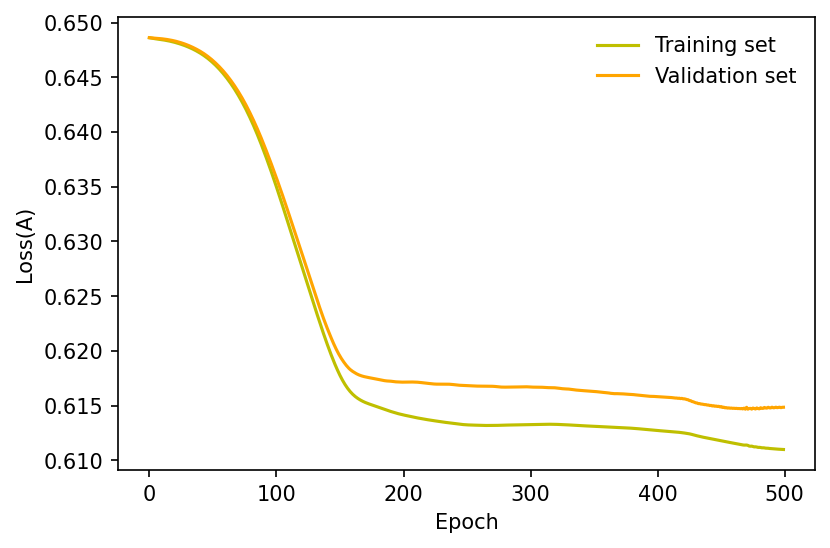

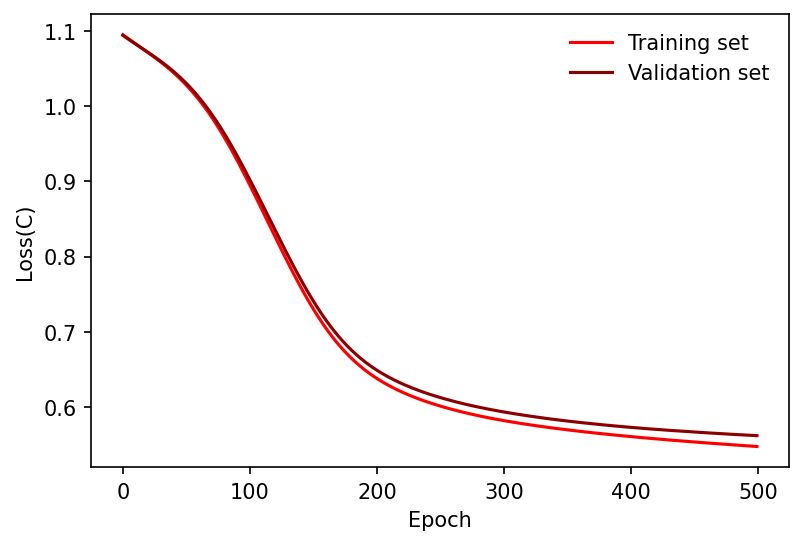

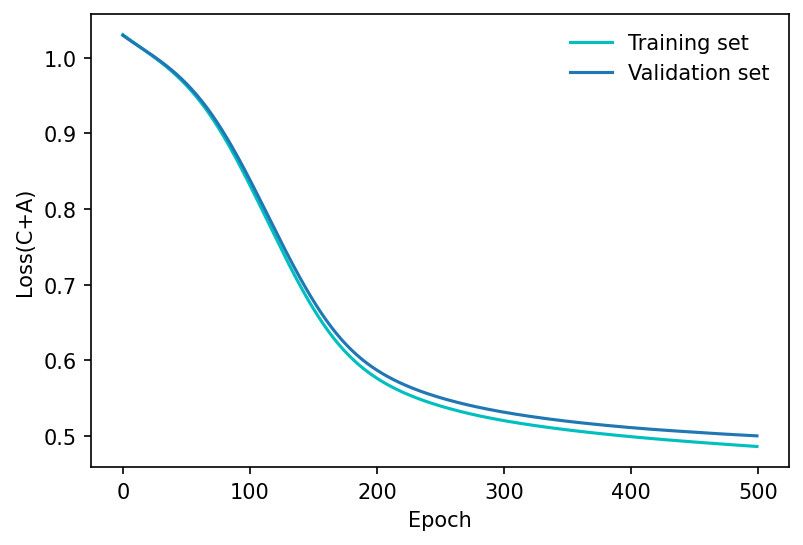

In [10]:
acc = adnn.fit (X.astype(np.float32), Y.astype(np.float32), Y_adv.astype(np.float32), X_val.astype(np.float32), Y_val.astype(np.float32), Y_adv_val.astype(np.float32))

# How do we quantify the ADNN performance

Now that our model is trained we want to know how well it will perform on a test dataset that has not been used to train it. But we will look also at the training dataset itself to search for signs of overtraining.

In the following we will look at several distributions and plots that will help us to quantify the ADNN performance.

## Plot the probability distributions for the three output nodes of C

First, we can look at the output distributions of the classifier. Remember that we have used a *softmax* activation function for the last layer, therefore the 3 outputs are forced to sum to unity and can be interpreted as probabilities.

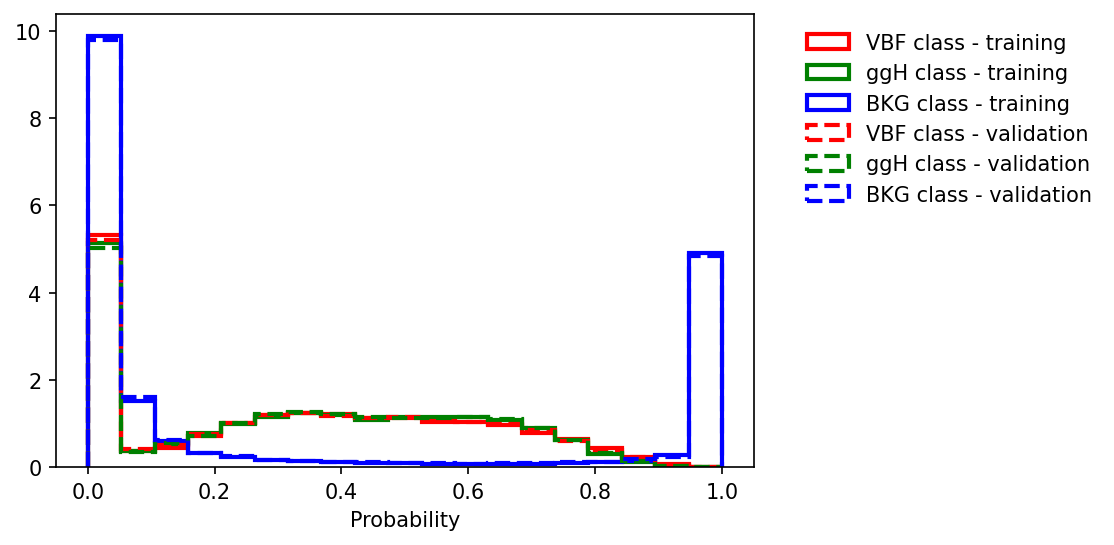

In [15]:
Y_predict_train = adnn.predict_proba(X)
Y_predict_val = adnn.predict_proba(X_val)

axis = np.linspace(0,1,20)

plt.hist(Y_predict_train[:,0].numpy(), bins = axis, label = 'VBF class - training',  histtype='step', color='r',  density=True, linewidth=2 )
plt.hist(Y_predict_train[:,1].numpy(), bins = axis, label = 'ggH class - training',  histtype='step', color='g',  density=True, linewidth=2 )
plt.hist(Y_predict_train[:,2].numpy(), bins = axis, label = 'BKG class - training',  histtype='step', color='b',  density=True, linewidth=2 )
plt.hist(Y_predict_val[:,0].numpy(), bins = axis, label = 'VBF class - validation',  histtype='step', color='r',  density=True, linewidth=2, linestyle="dashed" )
plt.hist(Y_predict_val[:,1].numpy(), bins = axis, label = 'ggH class - validation',  histtype='step', color='g',  density=True, linewidth=2, linestyle="dashed" )
plt.hist(Y_predict_val[:,2].numpy(), bins = axis, label = 'BKG class - validation',  histtype='step', color='b',  density=True, linewidth=2, linestyle="dashed" )

plt.xlabel("Probability")
plt.legend(frameon=False, bbox_to_anchor=(1.05, 1.))
plt.show()

## Plot the probability distributions for labelled events

We can now look at the probability distributions of the 3 output nodes using the known labels (`isVBF`, `isGGH`, `isBKG`) of our events.

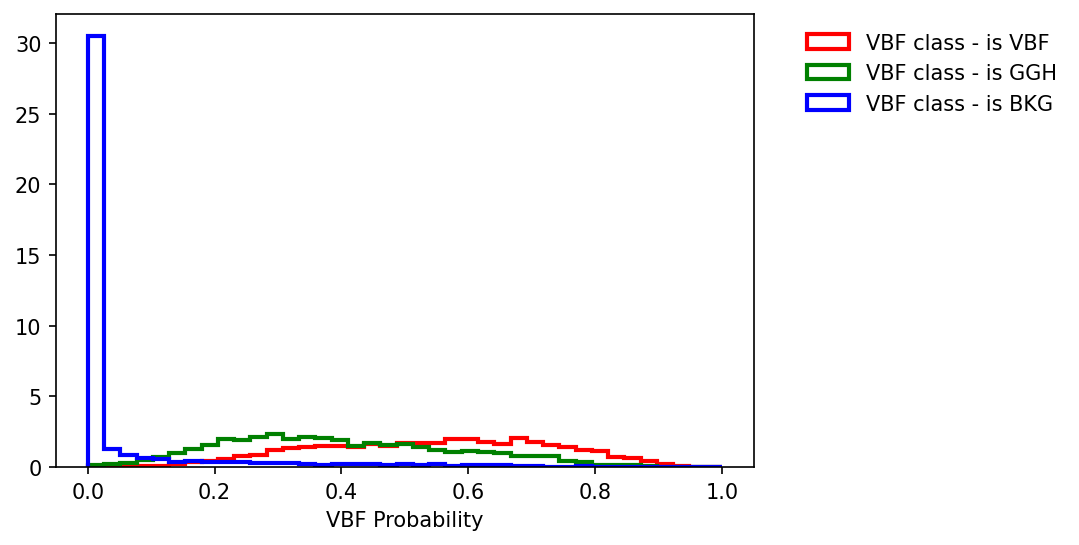

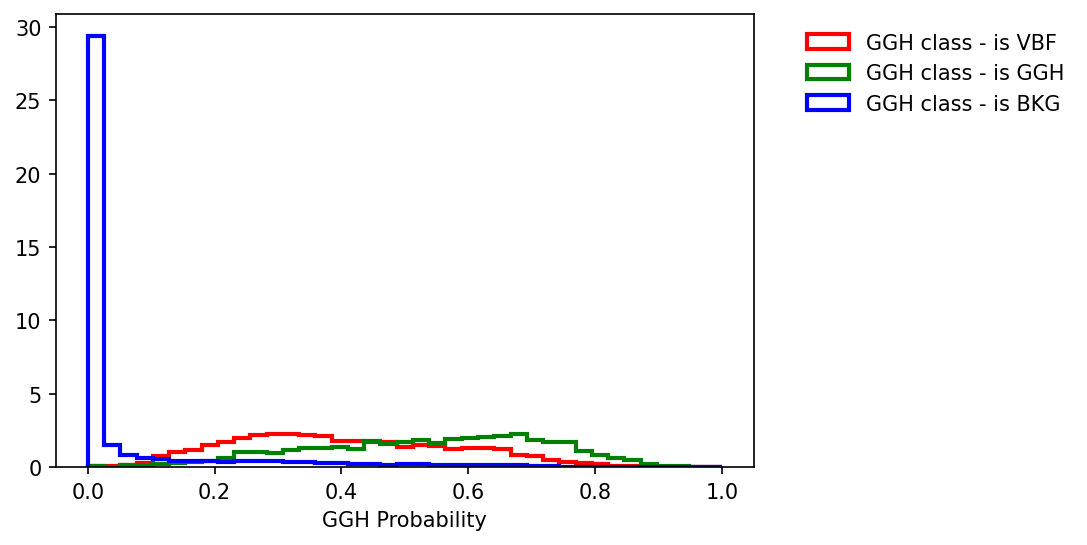

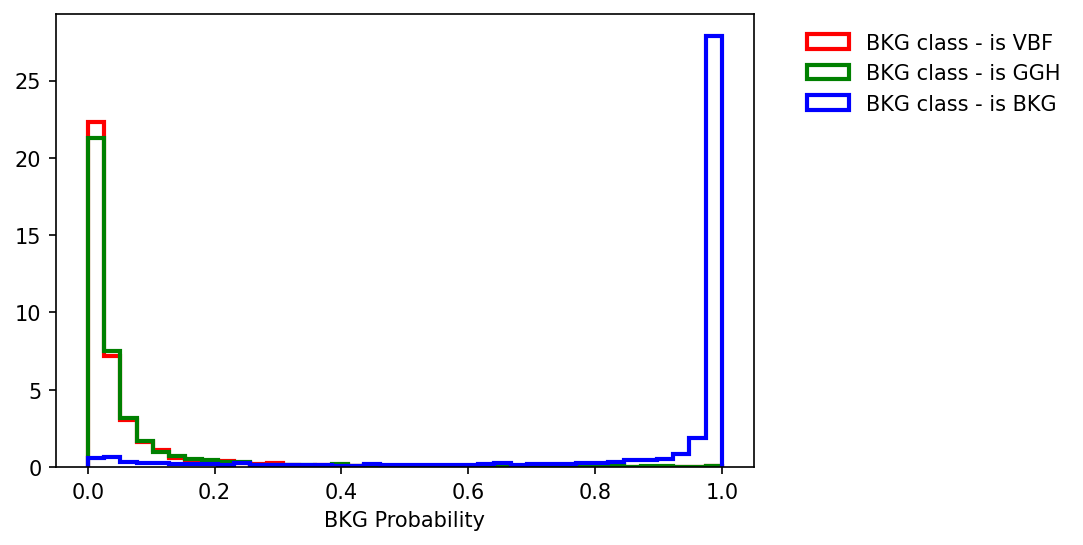

In [16]:
# Explanation of the sintax used below
# adnn.predict_proba( df_val[ df_val['isVBF']==1 ].values[:,0:NDIM] )[:,0]
#                                      ^                    ^           ^
#                                      |                    |           |
#                                select VBF events          |           |
#                                               get the input features  |
#                                                             select the VBF output node (i.e. node 0)
pred_isvbf = adnn.predict_proba( df_val[ df_val['isVBF']==1 ].values[:,0:NDIM] )
Y_predvbf_isvbf = pred_isvbf[:,0]
Y_predggh_isvbf = pred_isvbf[:,1]
Y_predbkg_isvbf = pred_isvbf[:,2]

pred_isggh = adnn.predict_proba( df_val[ df_val['isGGH']==1 ].values[:,0:NDIM] )
Y_predvbf_isggh = pred_isggh[:,0]
Y_predggh_isggh = pred_isggh[:,1]
Y_predbkg_isggh = pred_isggh[:,2]

pred_isbkg = adnn.predict_proba( df_val[ df_val['isBKG']==1 ].values[:,0:NDIM] )
Y_predvbf_isbkg = pred_isbkg[:,0]
Y_predggh_isbkg = pred_isbkg[:,1]
Y_predbkg_isbkg = pred_isbkg[:,2]

axis = np.linspace(0,1,40)

plt.hist(Y_predvbf_isvbf.numpy(), bins = axis, label = 'VBF class - is VBF',  histtype='step', color='r',  density=True, linewidth=2 )
plt.hist(Y_predvbf_isggh.numpy(), bins = axis, label = 'VBF class - is GGH',  histtype='step', color='g',  density=True, linewidth=2 )
plt.hist(Y_predvbf_isbkg.numpy(), bins = axis, label = 'VBF class - is BKG',  histtype='step', color='b',  density=True, linewidth=2 )
plt.xlabel("VBF Probability")
plt.legend(frameon=False, bbox_to_anchor=(1.05, 1.))
plt.show()

plt.hist(Y_predggh_isvbf.numpy(), bins = axis, label = 'GGH class - is VBF',  histtype='step', color='r',  density=True, linewidth=2 )
plt.hist(Y_predggh_isggh.numpy(), bins = axis, label = 'GGH class - is GGH',  histtype='step', color='g',  density=True, linewidth=2 )
plt.hist(Y_predggh_isbkg.numpy(), bins = axis, label = 'GGH class - is BKG',  histtype='step', color='b',  density=True, linewidth=2 )
plt.xlabel("GGH Probability")
plt.legend(frameon=False, bbox_to_anchor=(1.05, 1.))
plt.show()

plt.hist(Y_predbkg_isvbf.numpy(), bins = axis, label = 'BKG class - is VBF',  histtype='step', color='r',  density=True, linewidth=2 )
plt.hist(Y_predbkg_isggh.numpy(), bins = axis, label = 'BKG class - is GGH',  histtype='step', color='g',  density=True, linewidth=2 )
plt.hist(Y_predbkg_isbkg.numpy(), bins = axis, label = 'BKG class - is BKG',  histtype='step', color='b',  density=True, linewidth=2 )
plt.xlabel("BKG Probability")
plt.legend(frameon=False, bbox_to_anchor=(1.05, 1.))
plt.show()

## Plot the probability distributions of different VBF signal models

If the output of the ADNN was model independent, we would expect to see statistically consistent distributions for the different VBF models. Let's then compare the VBF node distributions for all our models.

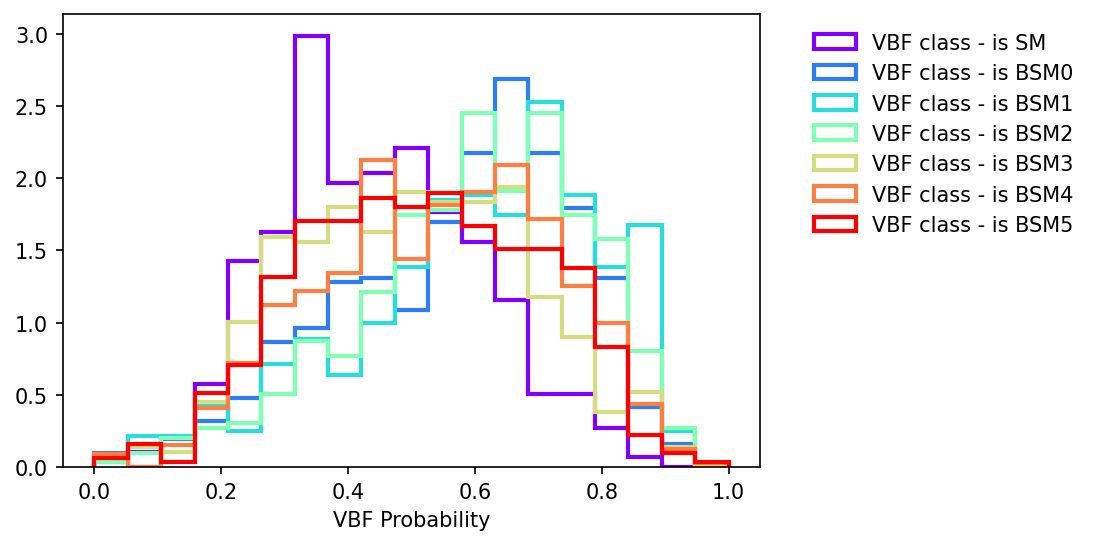

In [17]:
def plot_adversary_dists():
    color = cm.rainbow(np.linspace(0, 1, 7))

    pred_isvbfsm = adnn.predict_proba( df_val[ df_val['isSM']==1 ].values[:,0:NDIM] )
    Y_predvbf_isvbfsm = pred_isvbfsm[:,0]
    Y_predggh_isvbfsm = pred_isvbfsm[:,1]
    Y_predbkg_isvbfsm = pred_isvbfsm[:,2]

    axis = np.linspace(0,1,20)
    plt.hist(Y_predvbf_isvbfsm.numpy(), bins = axis, label = 'VBF class - is SM',  histtype='step', color=color[0],  density=True, linewidth=2 )

    for i in range(6):
        pred_isbsm = adnn.predict_proba( df_val[ df_val['isBSM'+str(i)]==1 ].values[:,0:NDIM] )
        Y_predvbf_isbsm = pred_isbsm[:,0]
        Y_predggh_isbsm = pred_isbsm[:,1]
        Y_predbkg_isbsm = pred_isbsm[:,2]
            
        plt.hist(Y_predvbf_isbsm.numpy(), bins = axis, label = 'VBF class - is BSM'+str(i),  histtype='step', color=color[i+1],  density=True, linewidth=2 )
    
    plt.xlabel("VBF Probability")
    plt.legend(frameon=False, bbox_to_anchor=(1.05, 1.))
    plt.show()

plot_adversary_dists()

## Plot the confusion matrices

Confusion matrices are useful tools to check in a visual way the classification power of our network. The following helper function can be used to make some nice plots.

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
#from matplotlib.backends.backend_pdf import PdfPages

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize = 16)
    plt.yticks(tick_marks, classes, fontsize = 16)

    thresh = cm.max() / 1.2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize=10)

    plt.xlabel("Predicted label", fontsize=16)
    plt.ylabel("True label", fontsize=16)

    
    plt.tight_layout()


We want to plot the classifier response matrix first.

Confusion Matrix Classifier
[[0.634 0.34  0.026]
 [0.323 0.642 0.034]
 [0.046 0.05  0.904]]
Classification Report
              precision    recall  f1-score   support

         VBF       0.63      0.63      0.63      4002
         ggH       0.62      0.64      0.63      4043
         BKG       0.94      0.90      0.92      3960

    accuracy                           0.73     12005
   macro avg       0.73      0.73      0.73     12005
weighted avg       0.73      0.73      0.73     12005



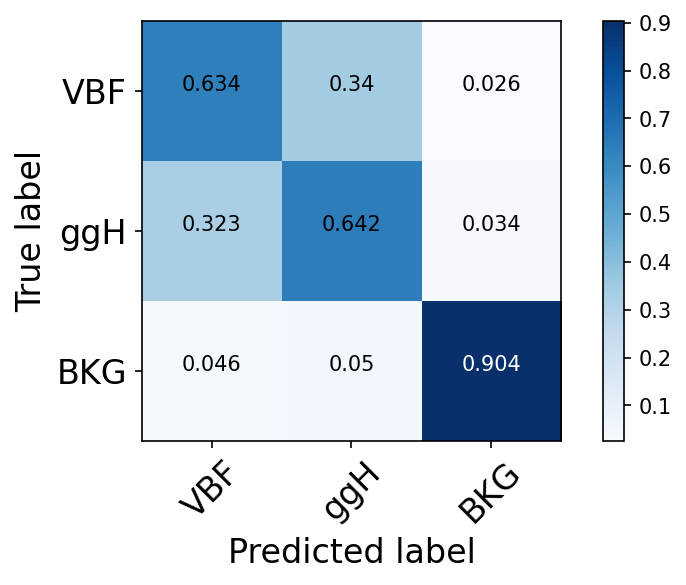

In [24]:
Y_pred_for_cm = adnn.predict_proba(X_val)

Y_true_max = np.argmax(Y_val, axis=1)
Y_pred_max = np.argmax(Y_pred_for_cm, axis=1)

print('Confusion Matrix Classifier')
C = confusion_matrix(Y_true_max, Y_pred_max, normalize="true")
C = np.around(C, decimals=3)
print(C)
print('Classification Report')
target_names = ['VBF','ggH','BKG']
print(classification_report(Y_true_max, Y_pred_max, target_names=target_names))

plt.figure()
plot_confusion_matrix(C, classes=target_names, title='')
plt.savefig('cm.pdf', dpi='figure', bbox_inches='tight',transparent=True)

plt.show(1)

And then the confusion matrix of the classifier. What do you expect in this case?

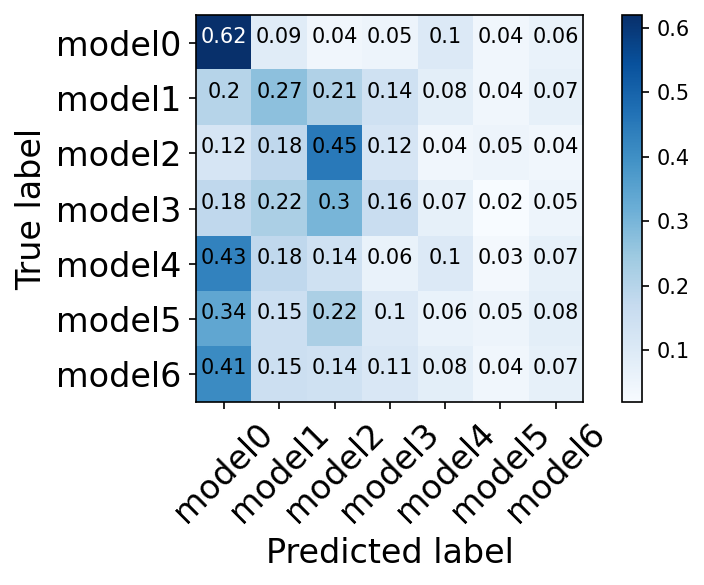

In [28]:
# Select a subset of the validation dataset containing only VBF (SM or BSM) events
X_val_for_cm = df_val[df_val["isVBF"]==1].values[:,0:NDIM]
Y_true_for_cm_adv = df_val[df_val["isVBF"]==1].values[:,NDIM+3:NDIM+10]
Y_pred_for_cm_adv = adnn.predict_proba_adv(X_val_for_cm)

Y_true_max_adv = np.argmax(Y_true_for_cm_adv, axis=1)
Y_pred_max_adv = np.argmax(Y_pred_for_cm_adv, axis=1)

C2 = confusion_matrix(Y_true_max_adv, Y_pred_max_adv, normalize="true")

C2 = np.around(C2, decimals=2)

## The one below is an alternative way to compute the confusion matrix by hand
## summing the predicted values in each matrix cell for all the events and 
## dividing by the sum of the values of a given row.

# C2 = np.ndarray(shape=(tf.shape(Y_pred_for_cm_adv)[1].numpy(), tf.shape(Y_pred_for_cm_adv)[1].numpy()))

# for ev in range(tf.shape(Y_pred_for_cm_adv)[0].numpy()):
#     for pred_label in range(C2.shape[1]):
#         C2[pred_label,Y_true_max_adv[ev]] += Y_pred_for_cm_adv[pred_label,Y_true_max_adv[ev]]

# C2 = np.around( C2/C2.sum(axis=1)[:,None],decimals=2)

target_names = ['model'+str(i) for i in range(7)]

plt.figure()
plot_confusion_matrix(C2, classes=target_names, title='')
plt.savefig('cm.pdf', dpi='figure', bbox_inches='tight',transparent=True)

plt.show(1)

## Quantitative metrics to evaluate the ADNN performance

Confusion matrices and nice looking, but let's now identify some possible quantitative metrics to assess the ADNN performance that can also be used later during the optimization.

In particular we will see the *categorical accuracy* score as a metric to quantify the overall classification performance, and two alternatives to evaluate the performance of the adversary.

In particular we can investigate two statistical tests:
- the 2-sample Kolmogorov-Smirnov test;
- the k-sample Anderson-Darling test.

In [18]:
from sklearn.metrics import accuracy_score
from scipy.stats import ks_2samp, anderson_ksamp

# The classifier categorical accuracy is a good and simple metrics to evaluate the overall classification performance
print("Classifier categorical accuracy = ", accuracy_score(Y_true_max, Y_pred_max))
# We don't care about the adversary accuracy actually... but still here it is
print("Adversary categorical accuracy = ", accuracy_score(Y_true_max_adv, Y_pred_max_adv))

# But how do we evaluate the performance of the adversary? 
# Remember that we want the classifier output distribution to be ~ the same for different signal models.
# Let's try to compute a 2-sample Kolmogorov-Smirnov test on each pair of different models.
# The larger (smaller) is the p-value (test statistic) the higher is the compatibility between the distributions.
preds = {}
preds['isSM'] = adnn.predict_proba( df_val[ df_val['isSM']==1 ].values[:,0:NDIM] )[:,0]
for i in range(6):
    preds['isBSM'+str(i)] = adnn.predict_proba( df_val[ df_val['isBSM'+str(i)]==1 ].values[:,0:NDIM] )[:,0]
    
for i in range(7):
    for j in range(i,6):
        label1 = 'isSM' if i==0 else 'isBSM'+str(i-1)
        label2 = 'isBSM'+str(j)
        print ( "KS between %s and %s --> " %(label1,label2),ks_2samp(preds[label1],preds[label2]) )

# An interesting alternative is the k-sample Anderson-Darling test.
# It tests the null hypothesis that k-samples are drawn from the same population without having to specify the distribution function of that population. 
samples_for_ad = np.array( (preds['isSM'].numpy(), preds['isBSM0'].numpy(), preds['isBSM1'].numpy(), 
                         preds['isBSM2'].numpy(), preds['isBSM3'].numpy(), preds['isBSM4'].numpy(),
                         preds['isBSM5'].numpy()) ).T

ad_stat, _, _ = anderson_ksamp(samples_for_ad)
print(ad_stat)

Classifier categorical accuracy =  0.7280352452766246
Adversary categorical accuracy =  0.24374842131851476
KS between isSM and isBSM0 -->  KstestResult(statistic=0.33665282836258054, pvalue=8.318012600200052e-29)
KS between isSM and isBSM1 -->  KstestResult(statistic=0.453248254331403, pvalue=6.2142332809555165e-55)
KS between isSM and isBSM2 -->  KstestResult(statistic=0.43554542189384027, pvalue=1.1816952226677851e-48)
KS between isSM and isBSM3 -->  KstestResult(statistic=0.1957614671989154, pvalue=5.928765256513202e-10)
KS between isSM and isBSM4 -->  KstestResult(statistic=0.24240534952836285, pvalue=6.994405055138486e-15)
KS between isSM and isBSM5 -->  KstestResult(statistic=0.17791206699657403, pvalue=1.6783759604344084e-08)
KS between isBSM0 and isBSM1 -->  KstestResult(statistic=0.132089846797808, pvalue=8.138174382144037e-05)
KS between isBSM0 and isBSM2 -->  KstestResult(statistic=0.10805442741529067, pvalue=0.002877025101474251)
KS between isBSM0 and isBSM3 -->  KstestRes

/tmp/ipykernel_230/4227403829.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  samples_for_ad = np.array( (preds['isSM'].numpy(), preds['isBSM0'].numpy(), preds['isBSM1'].numpy(),
/tmp/ipykernel_230/4227403829.py:30: UserWarning: p-value floored: true value smaller than 0.001
  ad_stat, _, _ = anderson_ksamp(samples_for_ad)


# Check the impact of the $\alpha$ hyperparameter

As you may have realized, the $\alpha$ parameter has a fundamental role in this procedure and has to be tuned with care in order to achieve the desired behavior.
Let's see what happens if we set $\alpha$ by hand to some arbitrary values.

## $\alpha = 0$ - no domain adaptation

The first case we may want to study is when $\alpha = 0$. This situation is essentially the same as dropping the adversary term, given that the adversary loss has no impact (it is multiplied by 0) on the overall loss.

But note that some level of domain adaptation is still there, given that we are training our network on a dataset that is composed of different VBF signal models in equal proportions.

To avoid any bias in the training procedure, we reset the optimizers initial state with the `reset_optimizers()` helper function, as well as the initial values of the model weights (`load_weights("my_model_init")`).

100%|██████████| 500/500 [00:36<00:00, 13.83it/s]


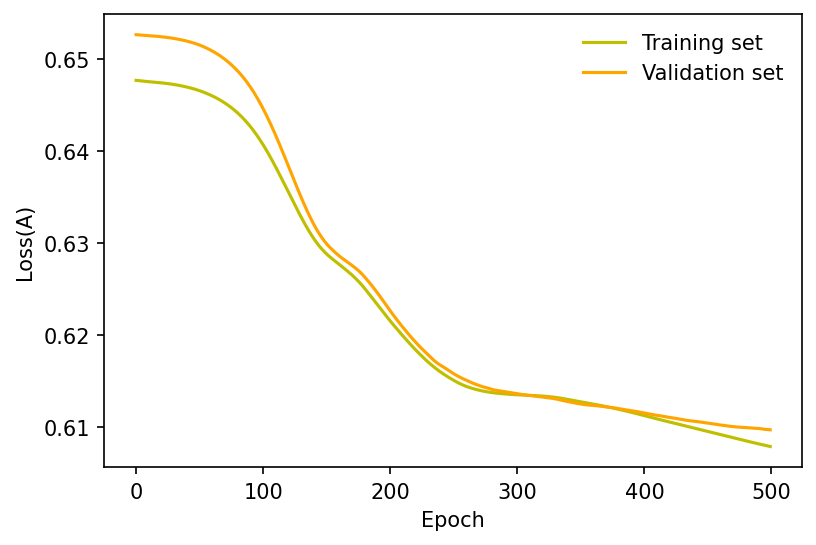

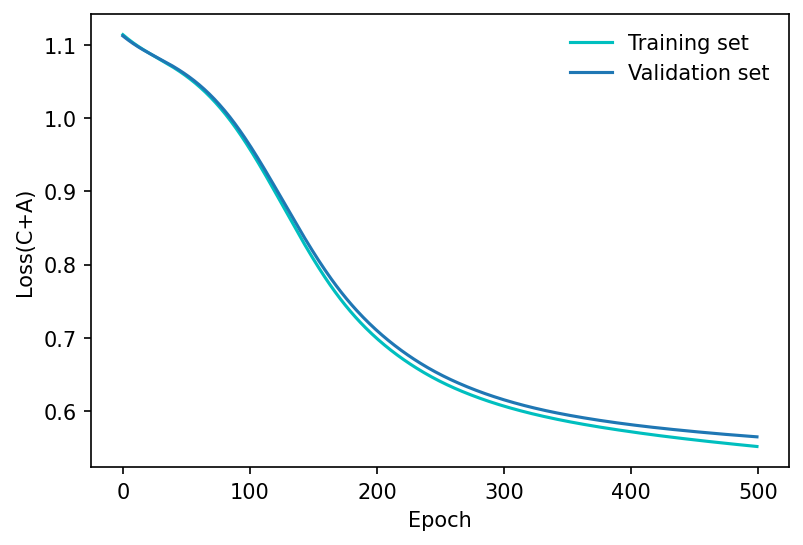

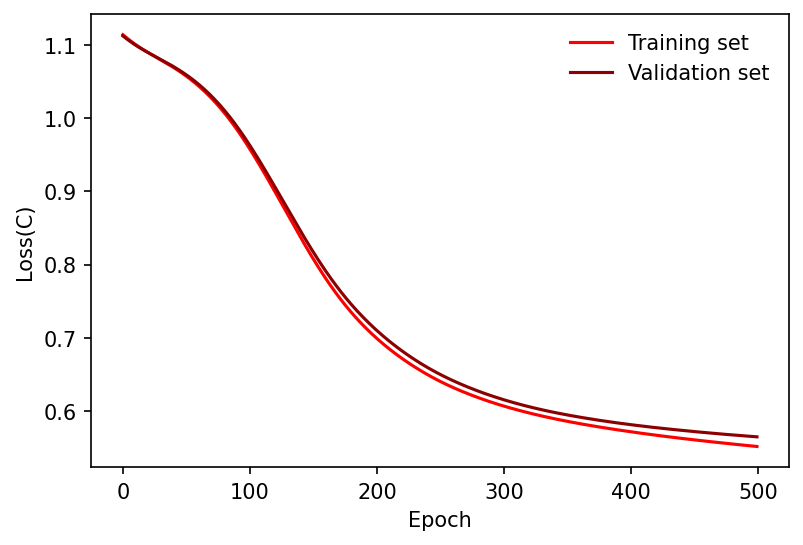

In [19]:
# Let's try to change the alpha hyperparameter but keeping the rest unchanged
adnn.reset_optimizers()
adnn.load_weights("my_model_init")
adnn.set_alpha(0.)
acc = adnn.fit (X.astype(np.float32), Y.astype(np.float32), Y_adv.astype(np.float32), X_val.astype(np.float32), Y_val.astype(np.float32), Y_adv_val.astype(np.float32))
adnn.save_weights("my_model_alpha0")

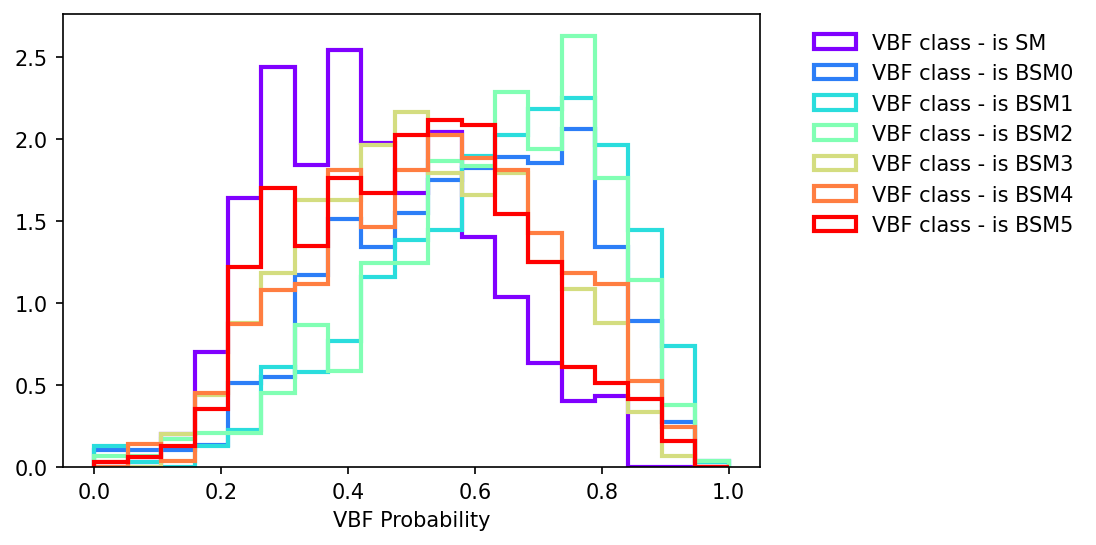

Classifier categorical accuracy =  0.7284588663899009


In [20]:
# Let's now check the performance of the ADNN and look at the output distributions
plot_adversary_dists()

Y_pred_for_cm = adnn.predict_proba(X_val)
Y_true_max = np.argmax(Y_val, axis=1)
Y_pred_max = np.argmax(Y_pred_for_cm, axis=1)

print("Classifier categorical accuracy = ", accuracy_score(Y_true_max, Y_pred_max))


## $\alpha = 0.01$ - let's start increasing gradually the adversary importance

In [ ]:
# Let's try to change the alpha hyperparameter but keeping the rest unchanged
adnn.reset_optimizers()
adnn.load_weights("my_model_init")
adnn.set_alpha(0.01)
acc = adnn.fit (X.astype(np.float32), Y.astype(np.float32), Y_adv.astype(np.float32), X_val.astype(np.float32), Y_val.astype(np.float32), Y_adv_val.astype(np.float32))

In [ ]:
# Let's now check the performance of the ADNN and look at the output distributions
plot_adversary_dists()

print("Classifier categorical accuracy = ", accuracy_score(Y_true_max, Y_pred_max))


## $\alpha = 0.1$ - let's start increasing gradually the adversary importance

In [ ]:
# Let's try to change the alpha hyperparameter but keeping the rest unchanged
adnn.reset_optimizers()
adnn.load_weights("my_model_init")
adnn.set_alpha(0.1)
acc = adnn.fit (X.astype(np.float32), Y.astype(np.float32), Y_adv.astype(np.float32), X_val.astype(np.float32), Y_val.astype(np.float32), Y_adv_val.astype(np.float32))

In [ ]:
# Let's now check the performance of the ADNN and look at the output distributions
plot_adversary_dists()


Y_pred_for_cm = adnn.predict_proba(X_val)
Y_true_max = np.argmax(Y_val, axis=1)
Y_pred_max = np.argmax(Y_pred_for_cm, axis=1)

print("Classifier categorical accuracy = ", accuracy_score(Y_true_max, Y_pred_max))


## $\alpha = 1$ - let's start increasing gradually the adversary importance

In [ ]:
# Let's try to change the alpha hyperparameter but keeping the rest unchanged
adnn.reset_optimizers()
adnn.load_weights("my_model_init")
adnn.set_alpha(1)
acc = adnn.fit (X.astype(np.float32), Y.astype(np.float32), Y_adv.astype(np.float32), X_val.astype(np.float32), Y_val.astype(np.float32), Y_adv_val.astype(np.float32))

In [ ]:
# Let's now check the performance of the ADNN and look at the output distributions
plot_adversary_dists()


Y_pred_for_cm = adnn.predict_proba(X_val)
Y_true_max = np.argmax(Y_val, axis=1)
Y_pred_max = np.argmax(Y_pred_for_cm, axis=1)

print("Classifier categorical accuracy = ", accuracy_score(Y_true_max, Y_pred_max))


## $\alpha = 100$ - let's start increasing gradually the adversary importance

In [ ]:
# Let's try to change the alpha hyperparameter but keeping the rest unchanged
adnn.reset_optimizers()
adnn.load_weights("my_model_init")
adnn.set_alpha(100)
acc = adnn.fit (X.astype(np.float32), Y.astype(np.float32), Y_adv.astype(np.float32), X_val.astype(np.float32), Y_val.astype(np.float32), Y_adv_val.astype(np.float32))

In [ ]:
# Let's now check the performance of the ADNN and look at the output distributions
plot_adversary_dists()


Y_pred_for_cm = adnn.predict_proba(X_val)
Y_true_max = np.argmax(Y_val, axis=1)
Y_pred_max = np.argmax(Y_pred_for_cm, axis=1)

print("Classifier categorical accuracy = ", accuracy_score(Y_true_max, Y_pred_max))


# Tradeoff between accuracy and model dependence... How do we find a sweet spot?

We have seen that the choice of $\alpha$ is extremely important. The best value is a tradeoff between the accuracy of the classifier and the amount of model dependence.

We can use the **optuna** tool to find a sweet spot according to the metrics we have seen previously.

In [ ]:
# !pip install optuna

In [ ]:
import optuna

def evaluate_performance (trial) :
    alpha = trial.suggest_float ('alpha', 0.1, 100) 
    # N_NODES = trial.suggest_int('N_NODES',10, 100 )
    # n_layers1 = trial.suggest_int('n_layers1', 1,10)
    # n_layers2 = trial.suggest_int('n_layers2', 1, 10)
    #learning_rate1 = trial.suggest_float('learning_rate1', 1e-5, 1e-3)
    #learning_rate2 = trial.suggest_float('learning_rate2', 1e-4, 1e-2)
    
    # Load the initial weights (before training) and re-initialize the optimizers to always restart from the same initial set of weights
    adnn.reset_optimizers()
    adnn.load_weights("my_model_init")
    adnn.set_alpha(alpha)
    acc = adnn.fit (X.astype(np.float32), Y.astype(np.float32), Y_adv.astype(np.float32), X_val.astype(np.float32), Y_val.astype(np.float32), Y_adv_val.astype(np.float32))

    preds = {}
    preds['isSM'] = adnn.predict_proba( df_val[ df_val['isSM']==1 ].values[:,0:NDIM] )[:,0]
    for i in range(6):
        preds['isBSM'+str(i)] = adnn.predict_proba( df_val[ df_val['isBSM'+str(i)]==1 ].values[:,0:NDIM] )[:,0]

    ks_test_stat = 0
    comb=0
    for i in range(7):
        for j in range(i+1,6):
            label1 = 'isSM' if i==0 else 'isBSM'+str(i)
            label2 = 'isBSM'+str(j)
            stat, pval = ks_2samp(preds[label1],preds[label2])
            ks_test_stat += stat
            comb+=1
 
    ks_test_stat = ks_test_stat/comb
    
    Y_pred_for_cm = adnn.predict_proba(X_val)
    Y_true_max = np.argmax(Y_val, axis=1)
    Y_pred_max = np.argmax(Y_pred_for_cm, axis=1)

    ca = accuracy_score(Y_true_max, Y_pred_max)

    return ks_test_stat, ca

study = optuna.create_study(directions=['minimize', 'maximize'])
study.optimize(evaluate_performance,n_trials=3)

In [ ]:
optuna.visualization.matplotlib.plot_pareto_front(study, target_names=["Average K-S test", "Accuracy"])
#plt.rcParams["figure.figsize"] = (9,6)
#plt.rcParams["figure.dpi"] = 300
#plt.grid(color='grey', linestyle='--', linewidth=1, alpha=0.3)

plt.title(" ")
# grid(color='r', linestyle='-', linewidth=2)
plt.xlabel("Average K-S test", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.legend(prop={'size': 12},frameon=False)
plt.show()
# plt.savefig('pareto_lr_grey.pdf', dpi='figure', bbox_inches='tight',)
#plt.savefig('pareto_lr_white.pdf', dpi='figure', bbox_inches='tight', transparent = True)
#optuna.visualization.matplotlib.plot_optimization_history(study,target="Accuracy")
#plt.tight_layout()
opt_df = study.trials_dataframe()

In [ ]:
for best_trial in study.best_trials:
    
    print (opt_df[opt_df["number"]==best_trial.number][['values_0','values_1','params_alpha']])
    
# Reset matplotlib default style that gets overwritten by optuna
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['figure.dpi'] = 150

## Let's pick the $\alpha$ value corresponding to the best trial with the lowest mean K-S and train again

100%|██████████| 1000/1000 [01:13<00:00, 13.63it/s]


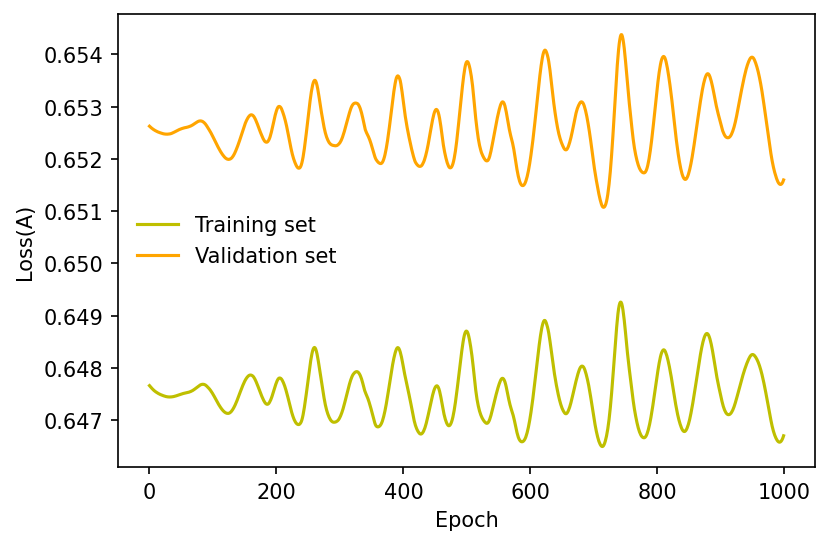

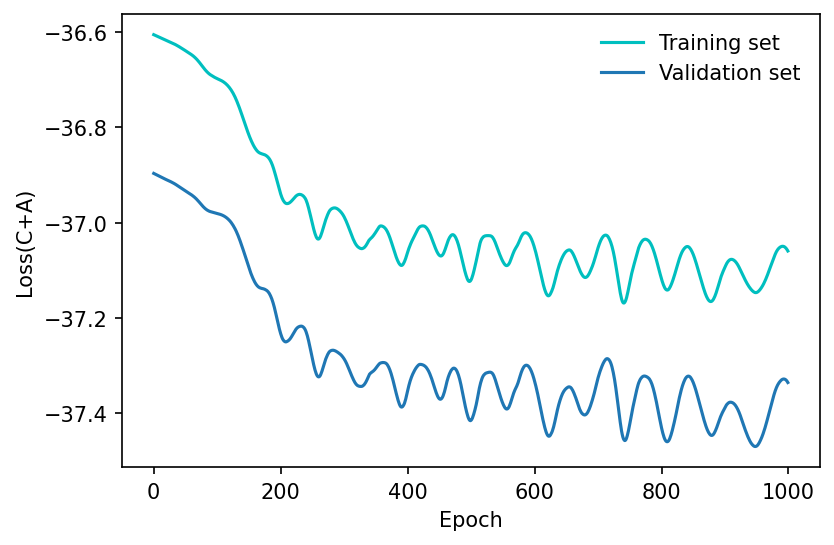

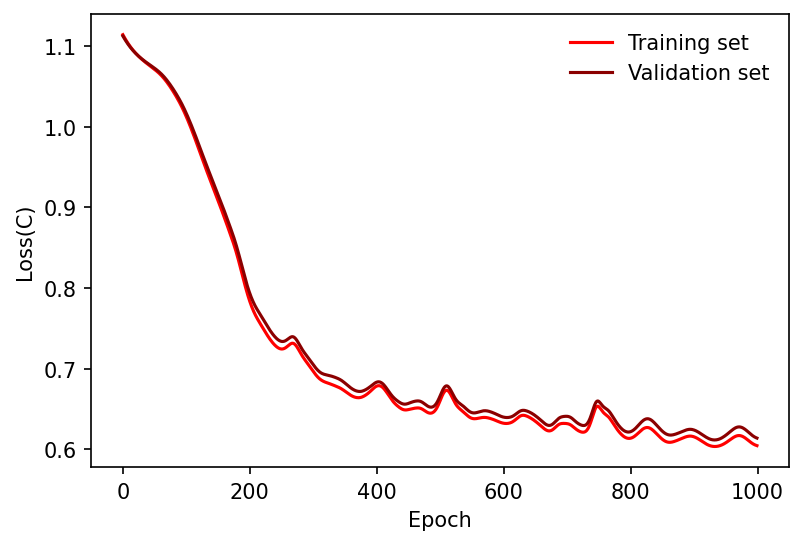

In [23]:
adnn.reset_optimizers()
adnn.load_weights("my_model_init")
adnn.set_alpha(58.24)
adnn.set_epochs(1000)
acc = adnn.fit (X.astype(np.float32), Y.astype(np.float32), Y_adv.astype(np.float32), X_val.astype(np.float32), Y_val.astype(np.float32), Y_adv_val.astype(np.float32))
adnn.save_weights("my_model_final")

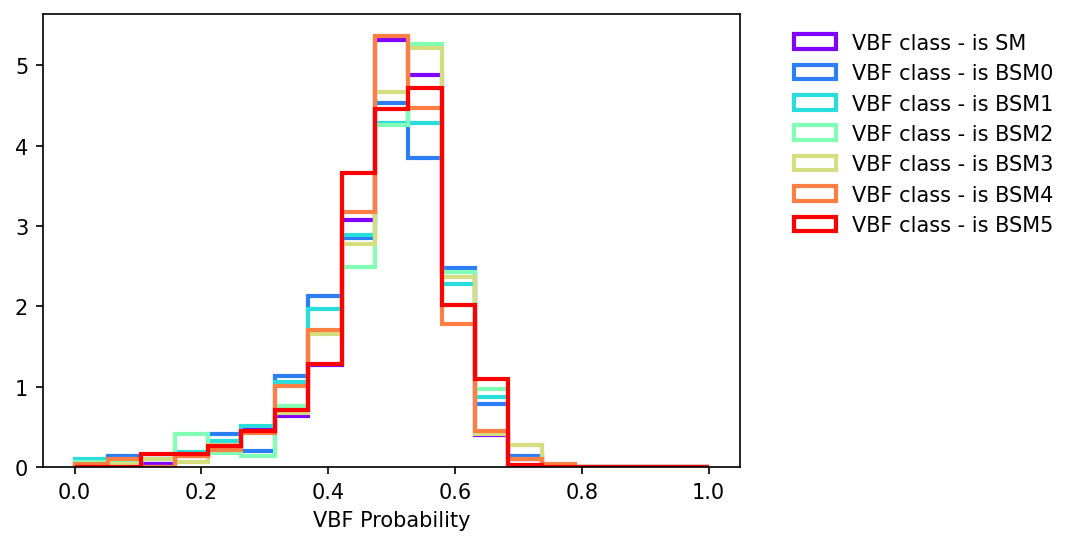

Classifier categorical accuracy =  0.6810133017029569


In [24]:
# Let's now check the performance of the ADNN and look at the output distributions
plot_adversary_dists()


Y_pred_for_cm = adnn.predict_proba(X_val)
Y_true_max = np.argmax(Y_val, axis=1)
Y_pred_max = np.argmax(Y_pred_for_cm, axis=1)

print("Classifier categorical accuracy = ", accuracy_score(Y_true_max, Y_pred_max))


# Summary

Let's finish summarizing the results. Perhaps you didn't realize, but we have actually analyzed two cases of Domain Adaptation:

1. a full-fledged Domain Adversarial Deep Neural Network;
2. a simpler approach in which we set $\alpha=0$. Note that this is still a Domain Adaptation approach (even without the adversarial term), because we trained the model on a dataset that contains events from both the source domain (SM VBF) and the target domain (BSM VBF). Also, note that in typical HEP applications the model is trained using only SM events.
3. Wait... but we haven't checked what happens in the typical application. As an excercise, let's train a simple DNN with the typical approach and compare with the previous two.

Let's run approach 3 in a separate [notebook](./Excercise_DA_MLhackathon_SimpleDNN.ipynb).

In [107]:
def summary():
    preds = {}
    preds['isSM'] = adnn.predict_proba( df_val[ df_val['isSM']==1 ].values[:,0:NDIM] )[:,0]
    for i in range(6):
        preds['isBSM'+str(i)] = adnn.predict_proba( df_val[ df_val['isBSM'+str(i)]==1 ].values[:,0:NDIM] )[:,0]

    ks_test_stat = 0
    comb=0
    for i in range(7):
        for j in range(i,6):
            label1 = 'isSM' if i==0 else 'isBSM'+str(i-1)
            label2 = 'isBSM'+str(j)
            stat, pval = ks_2samp(preds[label1],preds[label2])
            ks_test_stat += stat
            comb+=1
    ks_test_stat = ks_test_stat/comb
    print("Average K-S test stat = ", ks_test_stat)

    #And now the categorical accuracy for each of the 6 BSM models not seen in this training
    
    X      = df_val.values[:,0:NDIM]
    Y_true = df_val.values[:,NDIM:NDIM+3]

    Y_pred = adnn.predict_proba(X)

    Y_true_max = np.argmax(Y_true, axis=1)
    Y_pred_max = np.argmax(Y_pred, axis=1)
    print("Classifier categorical accuracy for SM-BSM model mixture = %s" %(accuracy_score(Y_true_max, Y_pred_max)))
    
    for i in range(7):
        label = 'isSM' if i==0 else 'isBSM'+str(i-1)
        X      = df_val[ (df_val[label]==1) | (df_val['isBKG']==1) | (df_val['isGGH']==1) ].values[:,0:NDIM]
        Y_true = df_val[ (df_val[label]==1) | (df_val['isBKG']==1) | (df_val['isGGH']==1) ].values[:,NDIM:NDIM+3]

        Y_pred = adnn.predict_proba(X)

        Y_true_max = np.argmax(Y_true, axis=1)
        Y_pred_max = np.argmax(Y_pred, axis=1)
        print("Classifier categorical accuracy for model %s = %s" %(label, accuracy_score(Y_true_max, Y_pred_max)))

        C = confusion_matrix(Y_true_max, Y_pred_max, normalize="true")
        C = np.around(C, decimals=3)
        print("Fraction of %s events classified as VBF = %s" %(label, C[0,0]))
 
        target_names = [label,'ggH','BKG']
        plt.figure()
        plot_confusion_matrix(C, classes=target_names, title='')
        plt.show(1) 

Average K-S test stat =  0.21775432211562168
Classifier categorical accuracy for SM-BSM model mixture = 0.7284588663899009
Classifier categorical accuracy for model isSM = 0.7465525439847837
Fraction of isSM events classified as VBF = 0.396


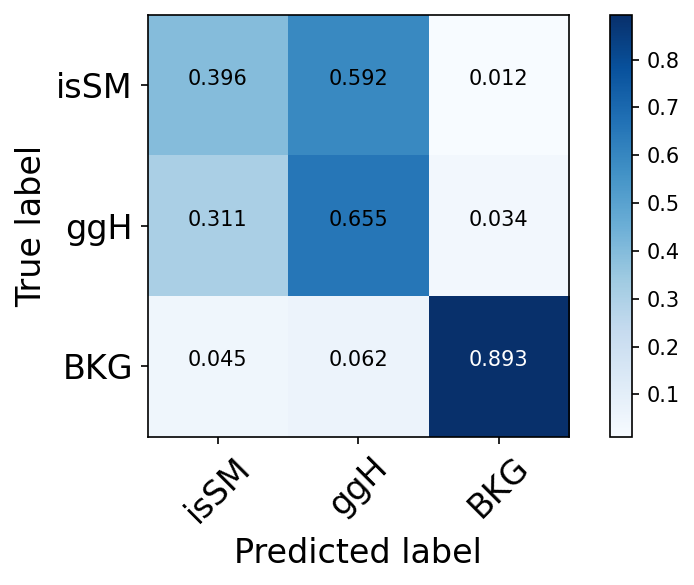

Classifier categorical accuracy for model isBSM0 = 0.7680123853757295
Fraction of isBSM0 events classified as VBF = 0.712


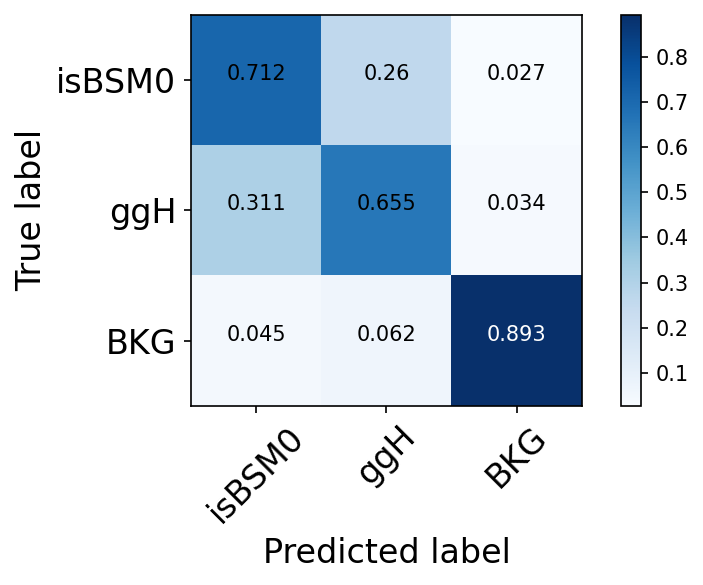

Classifier categorical accuracy for model isBSM1 = 0.7766449318316538
Fraction of isBSM1 events classified as VBF = 0.839


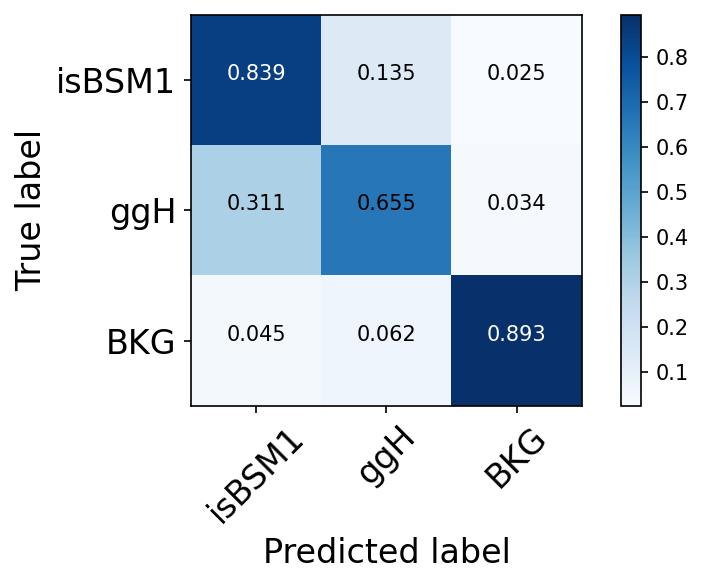

Classifier categorical accuracy for model isBSM2 = 0.7744549028952699
Fraction of isBSM2 events classified as VBF = 0.811


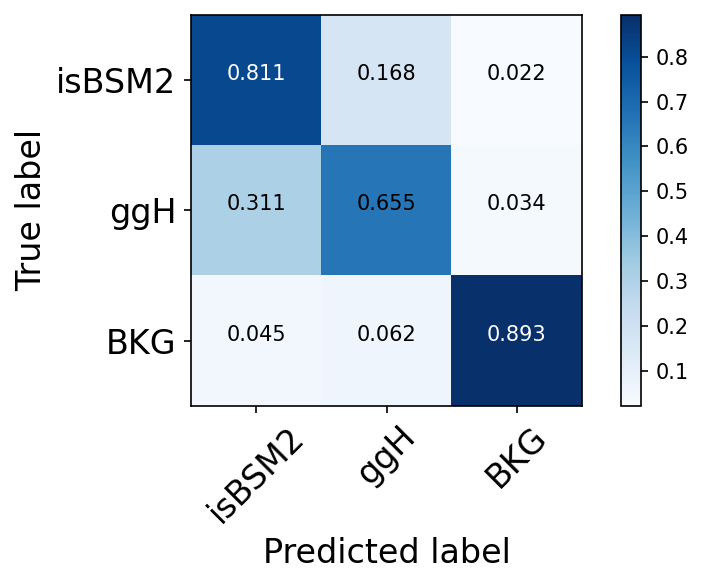

Classifier categorical accuracy for model isBSM3 = 0.7588340273646639
Fraction of isBSM3 events classified as VBF = 0.576


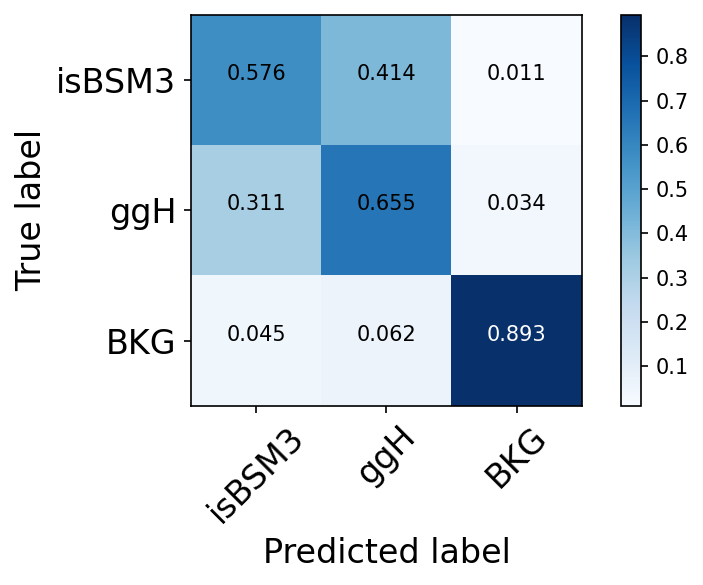

Classifier categorical accuracy for model isBSM4 = 0.7623077840028609
Fraction of isBSM4 events classified as VBF = 0.624


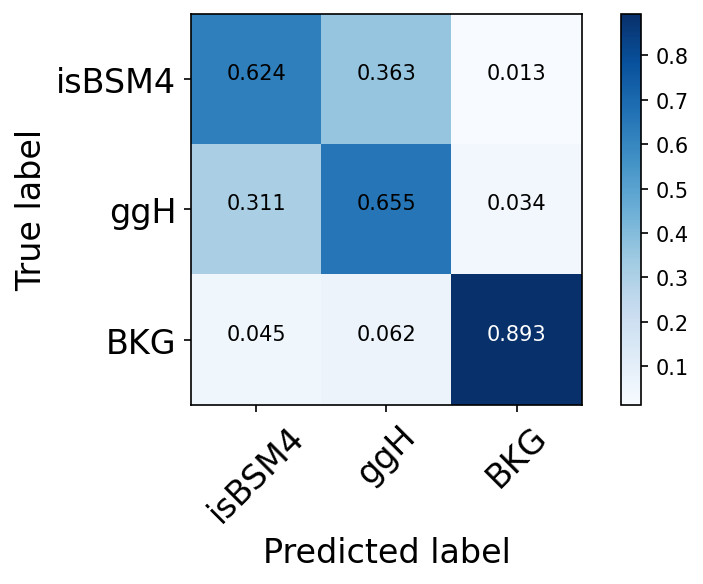

Classifier categorical accuracy for model isBSM5 = 0.7556899004267426
Fraction of isBSM5 events classified as VBF = 0.541


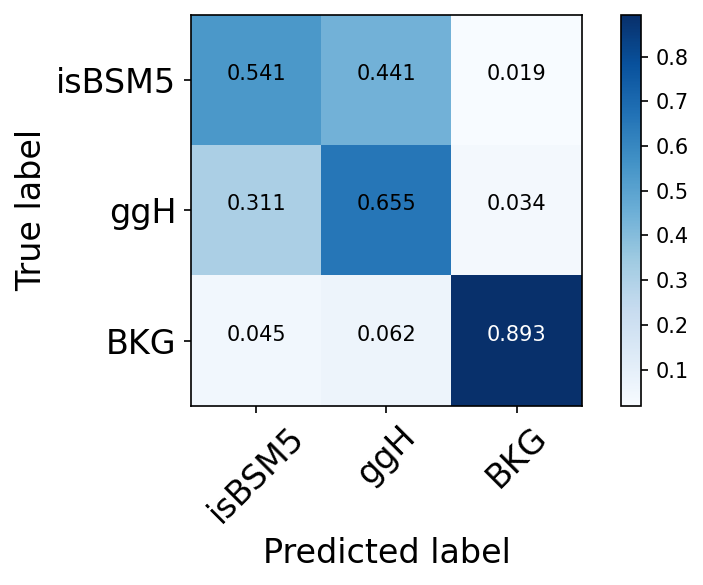

In [108]:
adnn.load_weights("my_model_alpha0")
summary()

Average K-S test stat =  0.0775190874907089
Classifier categorical accuracy for SM-BSM model mixture = 0.6810133017029569
Classifier categorical accuracy for model isSM = 0.6936519258202568
Fraction of isSM events classified as VBF = 0.68


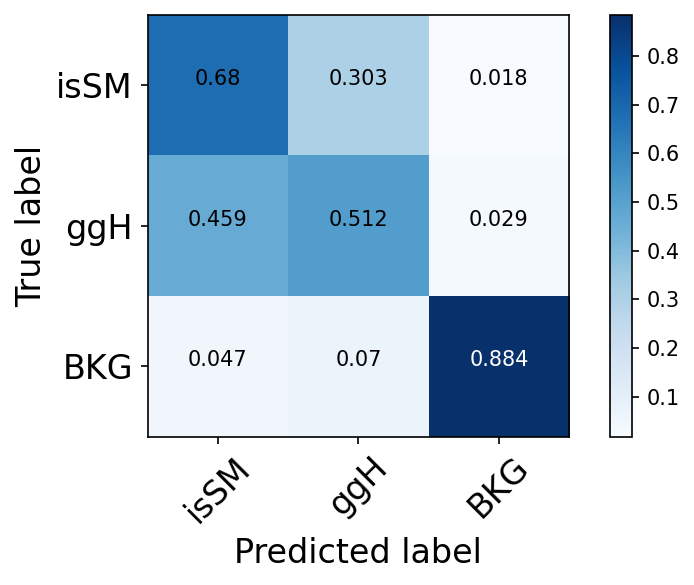

Classifier categorical accuracy for model isBSM0 = 0.6901274264618316
Fraction of isBSM0 events classified as VBF = 0.626


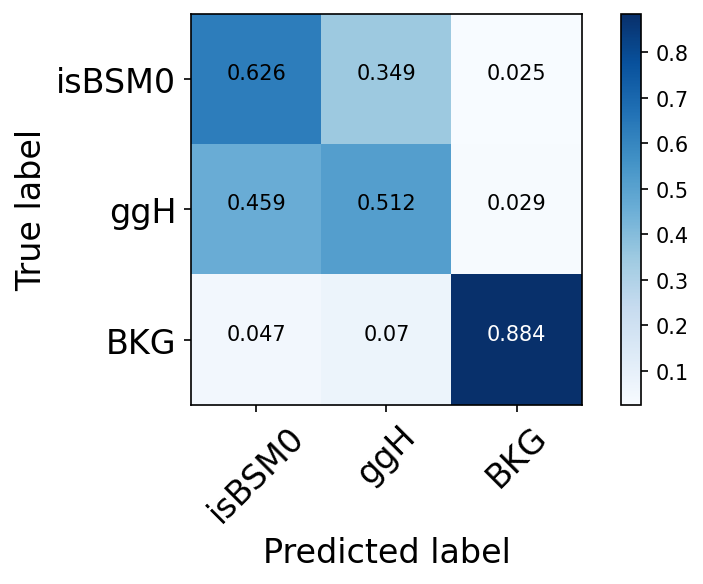

Classifier categorical accuracy for model isBSM1 = 0.6906935388263189
Fraction of isBSM1 events classified as VBF = 0.638


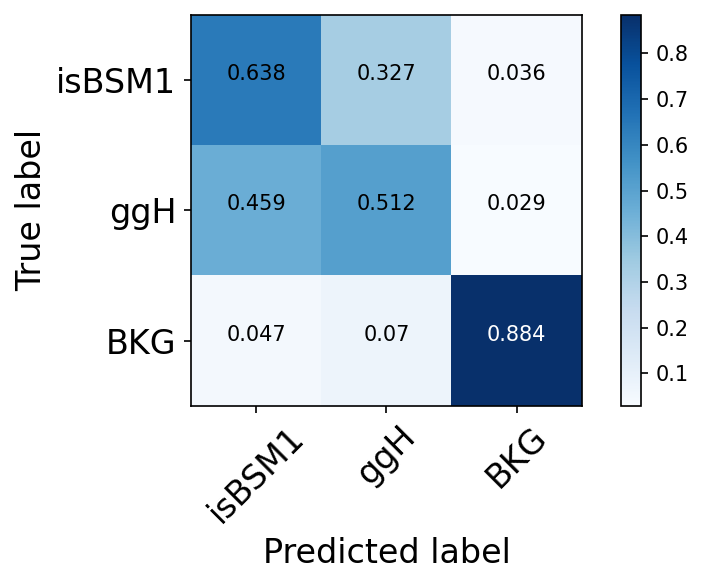

Classifier categorical accuracy for model isBSM2 = 0.6951030620755392
Fraction of isBSM2 events classified as VBF = 0.701


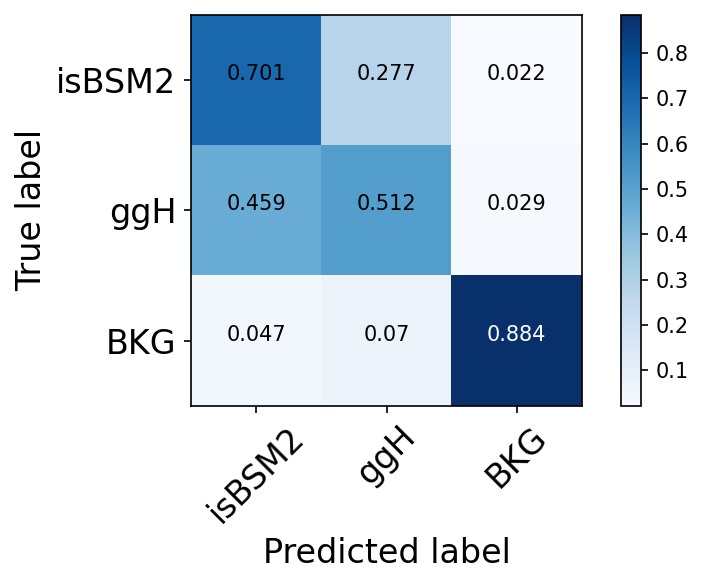

Classifier categorical accuracy for model isBSM3 = 0.6928019036287923
Fraction of isBSM3 events classified as VBF = 0.667


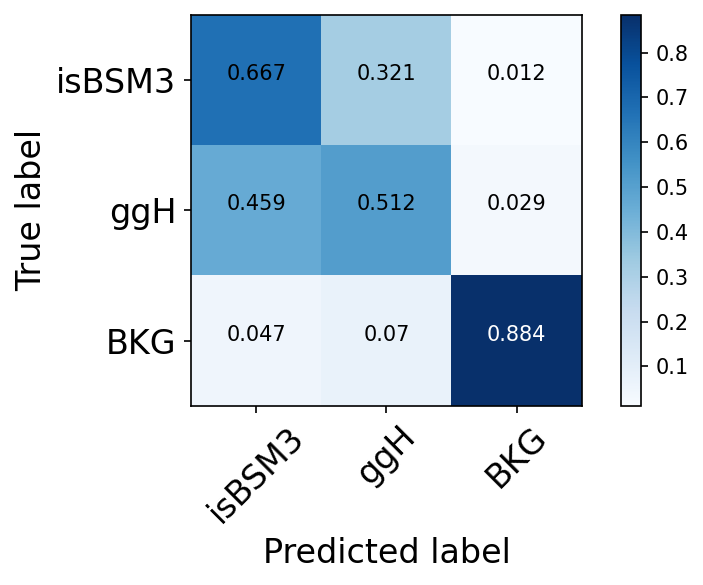

Classifier categorical accuracy for model isBSM4 = 0.6894743115985219
Fraction of isBSM4 events classified as VBF = 0.615


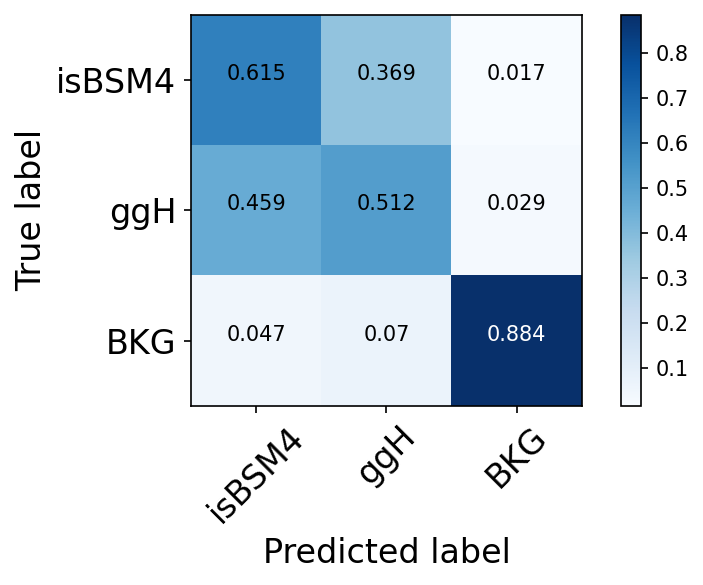

Classifier categorical accuracy for model isBSM5 = 0.6916785206258891
Fraction of isBSM5 events classified as VBF = 0.652


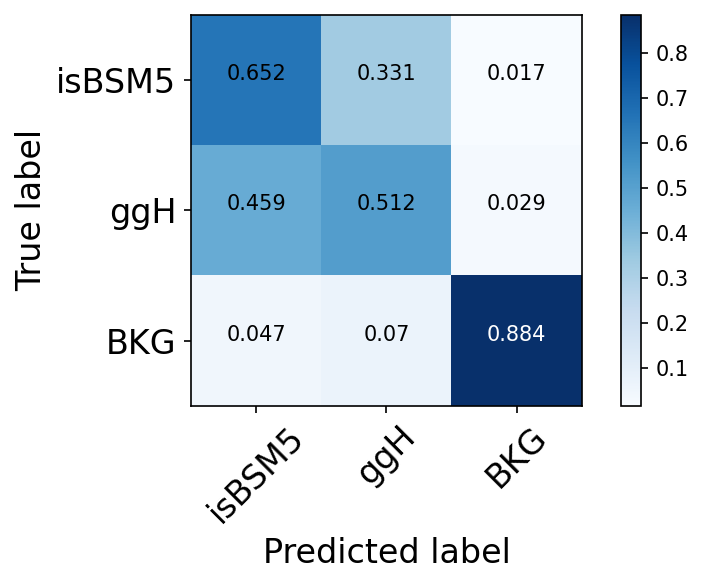

In [95]:
adnn.load_weights("my_model_final")
summary()

In summary, comparing the 3 approaches we have seen that:

1. The ADNN performance is characterized by a low average K-S test statistic and uniform categorical accuracies for all the models.
2. The ADNN with $\alpha=0$ seems to perform better if we only look at the categorical accuracies, but the average KS is fairly high and if we look at the confusion matrices in detail we can observe that there is a large variation in the fraction of signal events classified as VBF depending on the signal model.
3. The simple DNN has a fairly high accuracy if evaluated for SM events (i.e. target domain equal to the source domain), but starts to fail dramatically as soon as we evaluate it on one of the BSM models.

# References

- Camaiani B. et al., *Model independent measurements of standard model cross sections with domain adaptation*, EPJ C 82 921 (2022), [doi:10.1140/epjc/s10052-022-10871-3](https://doi.org/10.1140/epjc/s10052-022-10871-3)
- Ben-David S., Blitzer J., Crammer K. et al. *A theory of learning from different domains*. Mach. Learn. 79, 151–175 (2010). https://doi.org/10.1007/s10994-009-5152-4
- Louppe G., Kagan M., Cranmer K. *Learning to Pivot with Adversarial Networks*, [arXiv:1611.01046](https://arxiv.org/abs/1611.01046)
- Y. Ganin et al. *Domain-adversarial training of neural networks*. J. Mach. Learn. Res. 17, 2030–2096 (2016). [arXiv:1505.07818](https://arxiv.org/abs/1505.07818)

# BACKUP (Additional studies)

## Optimize using the AD test

In [ ]:
import optuna

def evaluate_performance (trial) :
    alpha = trial.suggest_float ('alpha', 0.1, 100) 
    # N_NODES = trial.suggest_int('N_NODES',10, 100 )
    # n_layers1 = trial.suggest_int('n_layers1', 1,10)
    # n_layers2 = trial.suggest_int('n_layers2', 1, 10)
    #learning_rate1 = trial.suggest_float('learning_rate1', 1e-5, 1e-3)
    #learning_rate2 = trial.suggest_float('learning_rate2', 1e-4, 1e-2)
    
    # Load the initial weights (before training) and re-initialize the optimizers to always restart from the same initial set of weights
    adnn.reset_optimizers()
    adnn.load_weights("my_model_init")
    adnn.set_alpha(alpha)
    acc = adnn.fit (X.astype(np.float32), Y.astype(np.float32), Y_adv.astype(np.float32), X_val.astype(np.float32), Y_val.astype(np.float32), Y_adv_val.astype(np.float32))

    preds = {}
    preds['isSM'] = adnn.predict_proba( df_val[ df_val['isSM']==1 ].values[:,0:NDIM] )[:,0]
    for i in range(6):
        preds['isBSM'+str(i)] = adnn.predict_proba( df_val[ df_val['isBSM'+str(i)]==1 ].values[:,0:NDIM] )[:,0]
    
    samples_for_ad = np.array( (preds['isSM'].numpy(), preds['isBSM0'].numpy(), preds['isBSM1'].numpy(), 
                         preds['isBSM2'].numpy(), preds['isBSM3'].numpy(), preds['isBSM4'].numpy(),
                         preds['isBSM5'].numpy()) ).T

    ad_stat, _, _ = anderson_ksamp(samples_for_ad)
    
    Y_pred_for_cm = adnn.predict_proba(X_val)
    Y_true_max = np.argmax(Y_val, axis=1)
    Y_pred_max = np.argmax(Y_pred_for_cm, axis=1)

    ca = accuracy_score(Y_true_max, Y_pred_max)

    return ad_stat, ca

study = optuna.create_study(directions=['minimize', 'maximize'])
study.optimize(evaluate_performance,n_trials=3)

In [ ]:
optuna.visualization.matplotlib.plot_pareto_front(study, target_names=["Average K-S test", "Accuracy"])
#plt.rcParams["figure.figsize"] = (9,6)
#plt.rcParams["figure.dpi"] = 300
#plt.grid(color='grey', linestyle='--', linewidth=1, alpha=0.3)

plt.title(" ")
# grid(color='r', linestyle='-', linewidth=2)
plt.xlabel("AD statistic", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.legend(prop={'size': 12},frameon=False)
plt.show()
# plt.savefig('pareto_lr_grey.pdf', dpi='figure', bbox_inches='tight',)
#plt.savefig('pareto_lr_white.pdf', dpi='figure', bbox_inches='tight', transparent = True)
#optuna.visualization.matplotlib.plot_optimization_history(study,target="Accuracy")
#plt.tight_layout()
opt_df = study.trials_dataframe()

for best_trial in study.best_trials:
    
    print (opt_df[opt_df["number"]==best_trial.number][['values_0','values_1','params_alpha']])
    
# Reset matplotlib default style that gets overwritten by optuna
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['figure.dpi'] = 150

In [ ]:
adnn.reset_optimizers()
adnn.load_weights("my_model_init")
adnn.set_alpha(1.674977)
acc = adnn.fit (X.astype(np.float32), Y.astype(np.float32), Y_adv.astype(np.float32), X_val.astype(np.float32), Y_val.astype(np.float32), Y_adv_val.astype(np.float32))

In [ ]:
# Let's now check the performance of the ADNN and look at the output distributions
plot_adversary_dists()


Y_pred_for_cm = adnn.predict_proba(X_val)
Y_true_max = np.argmax(Y_val, axis=1)
Y_pred_max = np.argmax(Y_pred_for_cm, axis=1)

print("Classifier categorical accuracy = ", accuracy_score(Y_true_max, Y_pred_max))


## Can we gain something by increasing the number of training epochs?

In [ ]:
adnn.reset_optimizers()
adnn.load_weights("my_model_init")
adnn.set_alpha(1.674977)
adnn.set_epochs(500)
acc = adnn.fit (X.astype(np.float32), Y.astype(np.float32), Y_adv.astype(np.float32), X_val.astype(np.float32), Y_val.astype(np.float32), Y_adv_val.astype(np.float32))

In [ ]:
plot_adversary_dists()


Y_pred_for_cm = adnn.predict_proba(X_val)
Y_true_max = np.argmax(Y_val, axis=1)
Y_pred_max = np.argmax(Y_pred_for_cm, axis=1)

print("Classifier categorical accuracy = ", accuracy_score(Y_true_max, Y_pred_max))

## Agnosticism against unseen physics models

**Questa parte non è molto utile ai fini dell'esercizio e forse si può togliere**

We may argue that the signal model chosen by Nature is unknown and in general different from the ones the discriminator has been trained on. This is indeed the primary reason why one wants the discriminator performance to be model independent in the first place. It is thus important to establish a procedure to evaluate the degree of model independence of the discriminator with respect to signal models unseen in the training.

In this specific use case, we want to check the performance of the *ADNN* for a given model that was not seen in the training. For achieving this goal, let's retrain the *ADNN* dropping one model (say `isBSM5`) from the dataset.

**NB** The results of this test are peculiar of the particular physics models taken into account.

In [ ]:
# First we need some manipulation of our dataset.
df_mod = df.copy()

# The isVBF label should now be one if either one of the isBSMi=1 excluding isBSM5
df_mod.iloc[:,NDIM+3:NDIM+9]
df_mod['isVBF'] = df_mod.iloc[:,NDIM+3:NDIM+9].sum(axis=1)

for col in df_mod.columns[24:35]:
    print (col, len(df_mod[df_mod[col]==1]))

# Now that we have excluded isBSM5, we should equalize again our dataset with respect to backgrounds
# Let's to that by simply throwing away random ggH and BKG events.
ggh_to_remove = len(df_mod[df_mod['isGGH']==1]) - len(df_mod[df_mod['isVBF']==1])
bkg_to_remove = len(df_mod[df_mod['isBKG']==1]) - len(df_mod[df_mod['isVBF']==1])

to_remove = np.random.choice(df_mod[df_mod['isGGH']==1].index, size=ggh_to_remove, replace=False)
df_mod = df_mod.drop(to_remove)
to_remove = np.random.choice(df_mod[df_mod['isBKG']==1].index, size=bkg_to_remove, replace=False)
df_mod = df_mod.drop(to_remove)

for col in df_mod.columns[24:35]:
    print (col, len(df_mod[df_mod[col]==1]))
    
# Perform the splitting and define training and validation datasets
msk = np.random.rand(len(df_mod)) < 0.8
df_mod_train = df_mod[msk]
df_mod_val = df_mod[~msk]

X = df_mod_train.values[:,0:NDIM]
Y = df_mod_train.values[:,NDIM:NDIM+3] # isVBF, isGGH, isBKG
# Remove isBSM5 in the training
Y_adv = df_mod_train.values[:,NDIM+3:NDIM+9] # isSM, isBSM0, isBSM1, ...

X_val = df_mod_val.values[:,0:NDIM]
Y_val = df_mod_val.values[:,NDIM:NDIM+3] # isVBF, isGGH, isBKG
Y_adv_val = df_mod_val.values[:,NDIM+3:NDIM+9] # isSM, isBSM0, isBSM1, ...

adnn = NeuralNetworkWithDomainAdaptation(500, learning_rate1=0.0001, learning_rate2= 0.0001, alpha=1.674977, N_NODES=50, n_layers1=5, n_layers2=5, 
                                         n_features=X.shape[1], n_outputsC=3, n_outputsA=6)
adnn.reset_optimizers()
acc = adnn.fit (X.astype(np.float32), Y.astype(np.float32), Y_adv.astype(np.float32), X_val.astype(np.float32), Y_val.astype(np.float32), Y_adv_val.astype(np.float32))


color = cm.rainbow(np.linspace(0, 1, 7))

pred_isvbfsm = adnn.predict_proba( df_mod_val[ df_mod_val['isSM']==1 ].values[:,0:NDIM] )
Y_predvbf_isvbfsm = pred_isvbfsm[:,0]
Y_predggh_isvbfsm = pred_isvbfsm[:,1]
Y_predbkg_isvbfsm = pred_isvbfsm[:,2]

axis = np.linspace(0,1,20)
plt.hist(Y_predvbf_isvbfsm.numpy(), bins = axis, label = 'VBF class - is SM',  histtype='step', color=color[0],  density=True, linewidth=2 )

for i in range(6):
    pred_isbsm = adnn.predict_proba( df_mod_val[ df_mod_val['isBSM'+str(i)]==1 ].values[:,0:NDIM] )
    Y_predvbf_isbsm = pred_isbsm[:,0]
    Y_predggh_isbsm = pred_isbsm[:,1]
    Y_predbkg_isbsm = pred_isbsm[:,2]
    
    if i==5:    plt.hist(Y_predvbf_isbsm.numpy(), bins = axis, label = 'VBF class - is BSM'+str(i),  histtype='step', color=color[i+1],  density=True, linewidth=4 )
    else:    plt.hist(Y_predvbf_isbsm.numpy(), bins = axis, label = 'VBF class - is BSM'+str(i),  histtype='step', color=color[i+1],  density=True, linewidth=2 )

plt.xlabel("VBF Probability")
plt.legend(frameon=False, bbox_to_anchor=(1.05, 1.))
plt.show()

# Y_pred_for_cm = adnn.predict_proba(X_val)
# Y_true_max = np.argmax(Y_val, axis=1)
# Y_pred_max = np.argmax(Y_pred_for_cm, axis=1)

# print("Classifier categorical accuracy = ", accuracy_score(Y_true_max, Y_pred_max))

In [32]:
adnn.model1.layers[4].get_weights()

[array([[ 0.18077695,  0.27803785, -0.06725125, ...,  0.22602503,
          0.15907735,  0.0815487 ],
        [ 0.02450965, -0.18725628, -0.13566858, ..., -0.03249398,
         -0.01343764,  0.2561823 ],
        [-0.22921434,  0.2544992 , -0.00676041, ...,  0.06860292,
          0.00038624, -0.19880193],
        ...,
        [ 0.11024053,  0.06063286, -0.02021214, ...,  0.05065162,
          0.21110106,  0.00902176],
        [-0.23679166, -0.1296108 , -0.05141363, ..., -0.16109142,
          0.21681158, -0.24752921],
        [-0.08915589, -0.17857355,  0.19438037, ...,  0.2695281 ,
          0.06926823,  0.12338831]], dtype=float32),
 array([ 0.00264217,  0.02624334, -0.01957345,  0.00579169,  0.01913774,
         0.02591265,  0.00874431,  0.01914593, -0.00294026,  0.01721052,
        -0.01637734,  0.0328375 ,  0.00249922,  0.02541338,  0.02781419,
         0.0160446 , -0.00076221,  0.00916958, -0.0060803 ,  0.00834042,
        -0.0050577 , -0.00273267, -0.01401524,  0.01820219, -0.007